## Problem statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 


The steps to be performed for the first task are given below.

- Exploratory data analysis
- Data cleaning
- Text preprocessing
- Feature extraction: In order to extract features from the text data, you may choose from any of the methods, including bag-of-words, TF-IDF vectorization or word embedding.
- Training a text classification model: You need to build at least three ML models. You then need to analyse the performance of each of these models and choose the best model. At least three out of the following four models need to be built (Do not forget, if required, handle the class imbalance and perform hyperparameter tuning.). 
    1. Logistic regression
    2. Random forest
    3. XGBoost
    4. Naive Bayes
 
Out of these four models, you need to select one classification model based on its performance.

Building a recommendation system
As you learnt earlier, you can use the following types of recommendation systems.
1. User-based recommendation system
2. Item-based recommendation system

Your task is to analyse the recommendation systems and select the one that is best suited in this case. 

Once you get the best-suited recommendation system, the next task is to recommend 20 products that a user is most likely to purchase based on the ratings. <br/>

You can use the 'reviews_username' (one of the columns in the dataset) to identify your user. 
- Improving the recommendations using the sentiment analysis model

Now, the next task is to link this recommendation system with the sentiment analysis model that was built earlier (recall that we asked you to select one ML model out of the four options). Once you recommend 20 products to a particular user using the recommendation engine, you need to filter out the 5 best products based on the sentiments of the 20 recommended product reviews. 

In this way, you will get an ML model (for sentiments) and the best-suited recommendation system. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import re
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

In [4]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [5]:
import pickle

import warnings
warnings.simplefilter("ignore")

In [6]:
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy

In [7]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mohit.dubey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohit.dubey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohit.dubey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohit.dubey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mohit.dubey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
from sklearn.linear_model import LogisticRegression
import time

In [9]:
%matplotlib inline

In [10]:
pd.set_option('display.max_colwidth', None)

# **Task 1: Data Cleaning and Pre-Processing**

## Helper functions

In [11]:
# Calculates the percentage of missing values in each column of a DataFrame.
# Args:
#   X (pandas.DataFrame): The input DataFrame.
# Returns:
#   pandas.DataFrame: A DataFrame containing the percentage of missing values for each column, sorted in descending order.
def get_missing_value_percentage(X):
  percent_missing = round((X.isnull().sum() / X.isnull().count()*100),3).to_frame('missing_percentage').sort_values('missing_percentage',ascending = False)
  return percent_missing


# Saves a DataFrame to a pickle file.
# Args:
#   df (pandas.DataFrame): The DataFrame to be saved.
def save_dataframe(df):
   df.to_pickle()


# Saves an object to a pickle file.
# Args:
#   obj: The object to be saved.
#   filename (str): The desired filename for the pickle file.
def save_object(obj, filename):
    pkl_filename = f"savedData/{filename}.pkl"
    with open(pkl_filename, 'wb') as files:
      pickle.dump(obj, files)

# Saves a machine learning model object to a pickle file with a timestamp.
# Args:
#   obj: The machine learning model object to be saved.
#   filename (str): The desired base filename for the pickle file.
# This function saves the model object to a pickle file with the following format:
# - Path: "savedData/models/"
# - Filename:
#     - Base filename provided by the user (e.g., "my_model")
#     - Underscore separator ("_")
#     - Timestamp in YYYYMMDD-HHMMSS format (e.g., "20241118-143923")
#     - ".pkl" extension
# Example:
#     save_model(my_model, "logistic_regression")  # Saves to "savedData/models/logistic_regression_20241118-143923.pkl"
def save_model(obj, filename):
    #datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +
    pkl_filename = f"savedData/models/{filename}.pkl"
    with open(pkl_filename, 'wb') as files:
      pickle.dump(obj, files)


# Gets a list of column values whose cumulative frequency is less than or equal to a given threshold.
# Args:
#   df (pandas.DataFrame): The input DataFrame.
#   column_name (str): The name of the column to analyze.
#   threshold (float): The threshold value for cumulative frequency.
# Returns:
#   list: A list of column values whose cumulative frequency is less than or equal to the threshold.
def get_columns_with_cumfreq(df, column_name,threshold):
    df_cat_freq = df[column_name].value_counts()
    df_cat_freq = pd.DataFrame({'column':df_cat_freq.index, 'value':df_cat_freq.values})
    df_cat_freq['perc'] = df_cat_freq['value'].cumsum()/df_cat_freq['value'].sum()
    return list(df_cat_freq.loc[df_cat_freq['perc']<=threshold].column)

### Load Data from Sample file and Meta file
#### Load the Metadata of Ebuss DF

In [12]:
ebuss_meta = pd.read_csv("dataset/Data+Attribute+Description.csv",  encoding='latin1')
ebuss_meta

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


#### Load the Ebuss Data in the dataframe

In [13]:
ebuss_df = pd.read_csv("dataset/sample30.csv")
ebuss_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [14]:
ebuss_df.shape, ebuss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

((30000, 15), None)

#### Get the unique value count for each column

In [15]:
ebuss_df.nunique()

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

In [16]:
get_missing_value_percentage(ebuss_df)

,missing_percentage
reviews_userProvince,99.433
reviews_userCity,93.570
reviews_didPurchase,46.893
reviews_doRecommend,8.567
reviews_title,0.633
manufacturer,0.470
reviews_username,0.210
reviews_date,0.153
user_sentiment,0.003
id,0.000


### **Observations**
- Total rows - `30000`
- Total of `271` unique products
- Total Categories - `270`
- Total unique users in reviews - `24914`
- `reviews_didPurchase`, `reviews_userCity` and `reviews_userProvince` has more than `40%` of missing values

### Drop the columns with more than 40% of missing values
Dropping columns `reviews_userProvince`, `reviews_userCity`, `reviews_didPurchase`

In [17]:
ebuss_df.drop(columns=["reviews_userProvince", "reviews_userCity", "reviews_didPurchase"],inplace=True)
get_missing_value_percentage(ebuss_df)

,missing_percentage
reviews_doRecommend,8.567
reviews_title,0.633
manufacturer,0.470
reviews_username,0.210
reviews_date,0.153
user_sentiment,0.003
id,0.000
brand,0.000
categories,0.000
name,0.000


In [18]:
round(ebuss_df[["reviews_doRecommend"]].value_counts(normalize=True) * 100, 2)

reviews_doRecommend
True                   94.35
False                   5.65
Name: proportion, dtype: float64

**As this `reviews_doRecommend` is skewed and will not help in analysis, we should drop this column**

In [19]:
ebuss_df_clean = ebuss_df.drop(columns=['reviews_doRecommend'])
get_missing_value_percentage(ebuss_df_clean)

,missing_percentage
reviews_title,0.633
manufacturer,0.470
reviews_username,0.210
reviews_date,0.153
user_sentiment,0.003
id,0.000
brand,0.000
categories,0.000
name,0.000
reviews_rating,0.000


### Nil value treatment
- `reviews_title` has only 0.6% of nil values. Replacing the the value with `unknown`
- `reviews_username` has only 0.2% of nil values. Replacing the the value with `unknown`

In [20]:
ebuss_df_clean['reviews_title'].fillna('unknown',inplace=True)
ebuss_df_clean['reviews_username'].fillna('unknown',inplace=True)
get_missing_value_percentage(ebuss_df_clean)

,missing_percentage
manufacturer,0.470
reviews_date,0.153
user_sentiment,0.003
id,0.000
brand,0.000
categories,0.000
name,0.000
reviews_rating,0.000
reviews_text,0.000
reviews_title,0.000


#### `manufacturer` coulmn treatment.
- Get the top 95% of manufacturer
- Replace the remaining manufacturer with others

In [21]:
top_manufacturers = get_columns_with_cumfreq(ebuss_df_clean, "manufacturer", 0.95)

# all the levels below 95 percentage are assgined to a single level called others
# get rows for levels which are not present in top_manufacturer_list
ebuss_new_df = ebuss_df_clean[~ebuss_df_clean['manufacturer'].isin(top_manufacturers)]

# replace the value of these levels to others
ebuss_new_df['manufacturer'] = "others"

# get rows for levels which are present in list_platform
ebuss_old_df = ebuss_df_clean[ebuss_df_clean['manufacturer'].isin(top_manufacturers)]

# concatenate new_df and old_df to get the final dataframe
ebuss_df_clean_updated = pd.concat([ebuss_new_df, ebuss_old_df])

get_missing_value_percentage(ebuss_df_clean_updated)

,missing_percentage
reviews_date,0.153
user_sentiment,0.003
id,0.000
brand,0.000
categories,0.000
manufacturer,0.000
name,0.000
reviews_rating,0.000
reviews_text,0.000
reviews_title,0.000


#### `review_date` nil value treatment
- Convert to date type
- Drop the missing rows for this column as just 0.15% is missing

In [22]:
#converting 'reviews_date' to date time object
ebuss_df_clean_updated["reviews_date"] = pd.to_datetime(ebuss_df_clean_updated["reviews_date"], errors='coerce')
ebuss_df_clean_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                30000 non-null  object             
 1   brand             30000 non-null  object             
 2   categories        30000 non-null  object             
 3   manufacturer      30000 non-null  object             
 4   name              30000 non-null  object             
 5   reviews_date      29255 non-null  datetime64[ns, UTC]
 6   reviews_rating    30000 non-null  int64              
 7   reviews_text      30000 non-null  object             
 8   reviews_title     30000 non-null  object             
 9   reviews_username  30000 non-null  object             
 10  user_sentiment    29999 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(9)
memory usage: 2.7+ MB


In [23]:
ebuss_df_clean_updated = ebuss_df_clean_updated[~ ebuss_df_clean_updated['reviews_date'].isna()]
get_missing_value_percentage(ebuss_df_clean_updated)

,missing_percentage
user_sentiment,0.003
id,0.000
brand,0.000
categories,0.000
manufacturer,0.000
name,0.000
reviews_date,0.000
reviews_rating,0.000
reviews_text,0.000
reviews_title,0.000


#### `user_sentiment` nil value treatment
- This column is skewed with most values as Positive
- Replace nil with Positive

In [24]:
round(ebuss_df_clean_updated.user_sentiment.value_counts(normalize=True) * 100, 2)

user_sentiment
Positive    88.8
Negative    11.2
Name: proportion, dtype: float64

In [25]:
ebuss_df_clean_updated['user_sentiment'].fillna('Positive', inplace=True)
get_missing_value_percentage(ebuss_df_clean_updated)

,missing_percentage
id,0.0
brand,0.0
categories,0.0
manufacturer,0.0
name,0.0
reviews_date,0.0
reviews_rating,0.0
reviews_text,0.0
reviews_title,0.0
reviews_username,0.0


In [26]:
ebuss_df_clean_updated['user_sentiment'] = ebuss_df_clean_updated['user_sentiment'].map({'Positive':1,'Negative':0})

### **Summarising treatment:**
- Removed the columns `reviews_didPurchase, reviews_userCity and reviews_userProvince` as it has more than 40% nil values
- Removed the column `reviews_doRecommend` as it was skewed and won't help in analysis
- For columns `review_title` and `review_username`, have set the nil values to `unkonwn`
- For column `manufacturer`, have set the last `5%` to `others`
- For column `review_date`, have removed the nil value entries `(0.15%)`
- For column `user_sentiment`, have set nil values to `Positive` as it is skewed towards `positive`
- Map `Positive` to `1` and `Negative` to `0` for column `user_sentiment`

## Understanding the distributions of features

### User sentiment feature distribution
- User Sentiment column has 88.8% positive and just 11.2% negative. This is a clear case of imbalance.

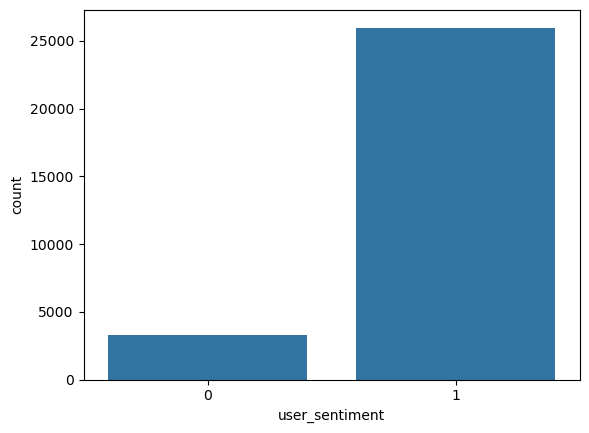

In [27]:
sns.countplot(x='user_sentiment', data = ebuss_df_clean_updated)
plt.show()


### Review feature distribution
- Almost `90%` of the ratings are either 4 star or 5 star

In [28]:
round(ebuss_df_clean_updated["reviews_rating"].value_counts(normalize=True) * 100, 2)


reviews_rating
5    69.49
4    20.23
1     4.51
3     4.45
2     1.33
Name: proportion, dtype: float64

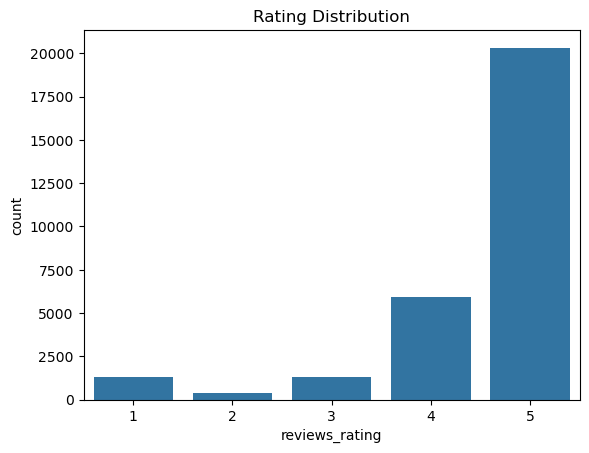

In [29]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated).set_title("Rating Distribution")
plt.show()


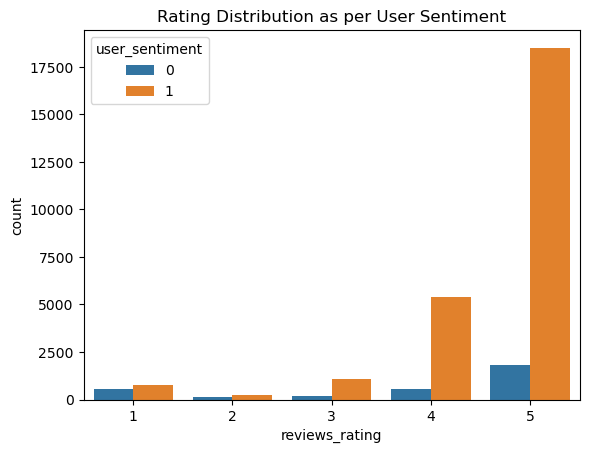

In [30]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated, hue="user_sentiment").set_title("Rating Distribution as per User Sentiment")
plt.show()


#### Products rating with negative Sentiment
- Around 70+% of negative sentiments has 4 or 5 star ratings

In [31]:
round(ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 0]["reviews_rating"].value_counts(normalize=True) * 100, 2)


reviews_rating
5    55.69
1    17.33
4    16.48
3     6.50
2     4.00
Name: proportion, dtype: float64

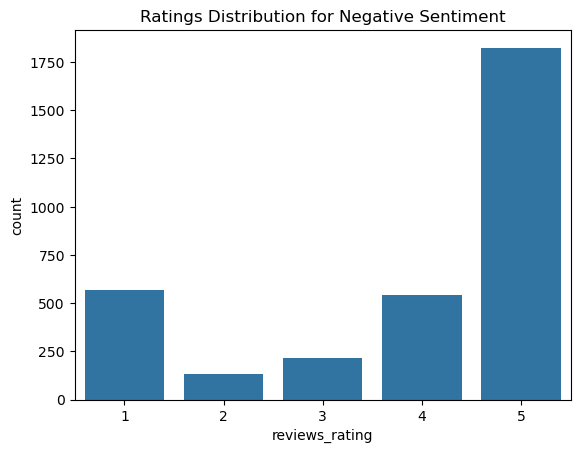

In [32]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 0]).set_title("Ratings Distribution for Negative Sentiment")
plt.show()


#### Products rating with positive Sentiment
- Around 8% of positive sentiments are less than 4 star

In [33]:
round(ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 1]["reviews_rating"].value_counts(normalize=True) * 100, 2)

reviews_rating
5    71.23
4    20.70
3     4.20
1     2.89
2     0.99
Name: proportion, dtype: float64

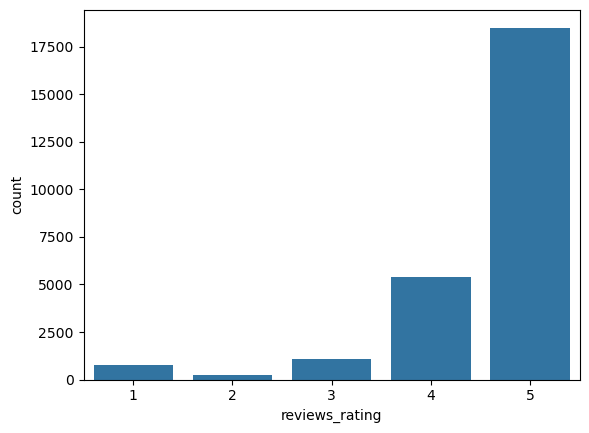

In [34]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 1])
plt.show()

#### Understanding the `user_sentiment` feature values
- Many Review with 4 or more stars will be assigned Positive sentiment
- Many Review with less than 4 star will be assigned negative sentiment

#### Samples with negative user sentiment but reviews 4 star or more

In [35]:
print(ebuss_df_clean_updated[(ebuss_df_clean_updated["user_sentiment"] == 0) & (ebuss_df_clean_updated["reviews_rating"] >= 4)].shape)
ebuss_df_clean_updated[(ebuss_df_clean_updated["user_sentiment"] == 0) & (ebuss_df_clean_updated["reviews_rating"] >= 4)][["name", "reviews_title", "reviews_text", "reviews_rating"]].sample(10)


(2365, 11)


,name,reviews_title,reviews_text,reviews_rating
15996,"Burt's Bees Lip Shimmer, Raisin",use instead of lipstick,I use this product instead of lipstick so I don't have to worry about what chemicals I am inadvertently swallowing.,5
23743,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Fun for one time wiewing ...,"Maybe not for a hardcore ""made in Japan"" Godzilla fans, still wort your time.",4
1030,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Good Stuff!,There is a reason this product has been around for so long! This review was collected as part of a promotion.,5
16454,"Burt's Bees Lip Shimmer, Raisin",Where did Cocoa go,"My 5 star rating is for the color Cocoa, but it is no longer offered. I am disappointed to learn that you Cocoa lip Shimmer is discontinued. I have been wearing it for years and the other colors do not compare. Please consider bringing it back. Without this color my rating would be a 1 because the colors are just not worth buying. Love the product but not the current colors available.",5
12507,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,great product,never disappoints! use Clorox for all my cleaning needs This review was collected as part of a promotion.,5
7316,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Smells good,Smells goodd dddddddddddddddddddddddddddddddddddddddddddddddddd This review was collected as part of a promotion.,4
16912,"Lundberg Wehani Rice, 25lb",Five Stars,thank you,5
12533,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Love with babies!,This product kills the funk off my kitchen counters!!! This review was collected as part of a promotion.,5
4039,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",Lovethis Folder,I like that I could place things of different heights in the pockets and also see them when I opened the folder. It will help not to have to go thru looking for smaller things and it also keeps them from falling out.,5
7056,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Grandma,"I keep clorox in my car and use it in public bathrooms, motels and even restaurants to sanitize . This review was collected as part of a promotion.",4


#### Samples with positive user sentiment but reviews less than 4 stars

In [36]:
print(ebuss_df_clean_updated[(ebuss_df_clean_updated["user_sentiment"] == 1) & (ebuss_df_clean_updated["reviews_rating"] < 4)].shape)
ebuss_df_clean_updated[(ebuss_df_clean_updated["user_sentiment"] == 1) & (ebuss_df_clean_updated["reviews_rating"] < 4)][["name", "reviews_title", "reviews_text", "reviews_rating"]].sample(10)


(2097, 11)


,name,reviews_title,reviews_text,reviews_rating
15744,"Burt's Bees Lip Shimmer, Raisin",...problem,"I tried this for the first time, and loved the look, but after a half hour or so, my lip started to swell.. it wasn't pleasant. my roommate had the same experience.",1
28485,"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",rocker,"Haven't really used it yet since we're waiting on baby to arrive. But it seems like a good value, is comfortable and was easy to assemble. Hopefully it will hold up.",3
21242,Nexxus Exxtra Gel Style Creation Sculptor,like the orginal much better,I was a faithful user of the original Gel I absolutely loved it but this new stuff is horrible whoever decided to change this should be fired!,1
23217,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,dark picture,"picture too dark, just not as good as other Godzillas",3
22030,Yes To Grapefruit Rejuvenating Body Wash,It's okay,"This soap has a really nice smell, and the packaging is pretty, but not in any way effective. I couldn't squeeze it out with the lid on, even using my entire body weight.Once I removed the lid, however, the soap was quite nice. The lather was a little lackluster, so I don't always feel like I had enough to wash my entire body. It also seemed to leave my skin a little dry and tight. That being said, it does smell great, I definitely feel clean after using it, and it doesn't aggravate my skin as most soaps tend to. It's very gentle, and an overall good experience once you fight your way passed the packaging.",3
21308,Nexxus Exxtra Gel Style Creation Sculptor,The scent is horrible,"Please bring back the old one, as others I have been using it for years and was very satisfied. I am bringing the new one back to the store and going to try to find a new gel that doesn't stink.",1
23056,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Good,Very good image is clear and nice I will buy again !!,3
21490,Nexxus Exxtra Gel Style Creation Sculptor,why did you change the formula,"The new formula is terrible...so oily and slick feeling!! Please go back to the old formula..I love the product, but have had to look else where to find something that compares to the old extra gel!!",1
1824,Mike Dave Need Wedding Dates (dvd + Digital),Crude film. Foul language through out.,What to say about this movie. There were some very funny parts. There are some very explicit parts as well. Not likely to watch again. You may want to rent this.,2
6550,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Good product,Product is great at santizeing countertops after prepping meals..,3


In [37]:
pd.crosstab(ebuss_df_clean_updated["user_sentiment"], ebuss_df_clean_updated["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,568,131,213,540,1825,3277
1,750,257,1090,5378,18503,25978
All,1318,388,1303,5918,20328,29255


#### `user_sentiment` value correction
- Positve with less than 4 rating will be assigned as negative
- Negative with 4 or more rating will be assigned positive

In [38]:
ebuss_df_clean_updated.loc[(ebuss_df_clean_updated["user_sentiment"]==1) & (ebuss_df_clean_updated["reviews_rating"]<4), "user_sentiment"] = 0
ebuss_df_clean_updated.loc[(ebuss_df_clean_updated["user_sentiment"]==0) & (ebuss_df_clean_updated["reviews_rating"]>=4), "user_sentiment"] = 1


In [39]:
pd.crosstab(ebuss_df_clean_updated["user_sentiment"], ebuss_df_clean_updated["reviews_rating"], margins=True)


reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,1318,388,1303,0,0,3009
1,0,0,0,5918,20328,26246
All,1318,388,1303,5918,20328,29255


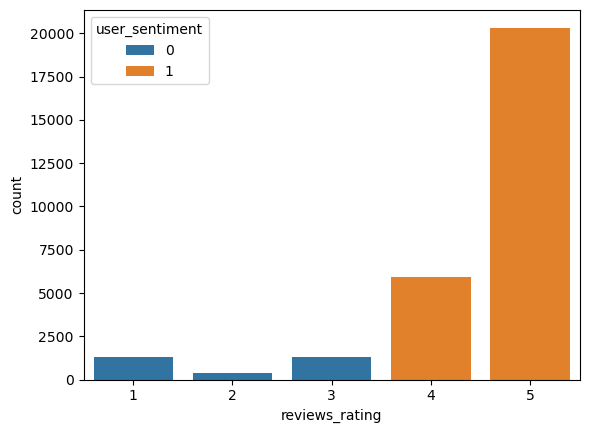

In [40]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated, hue="user_sentiment")
plt.show()

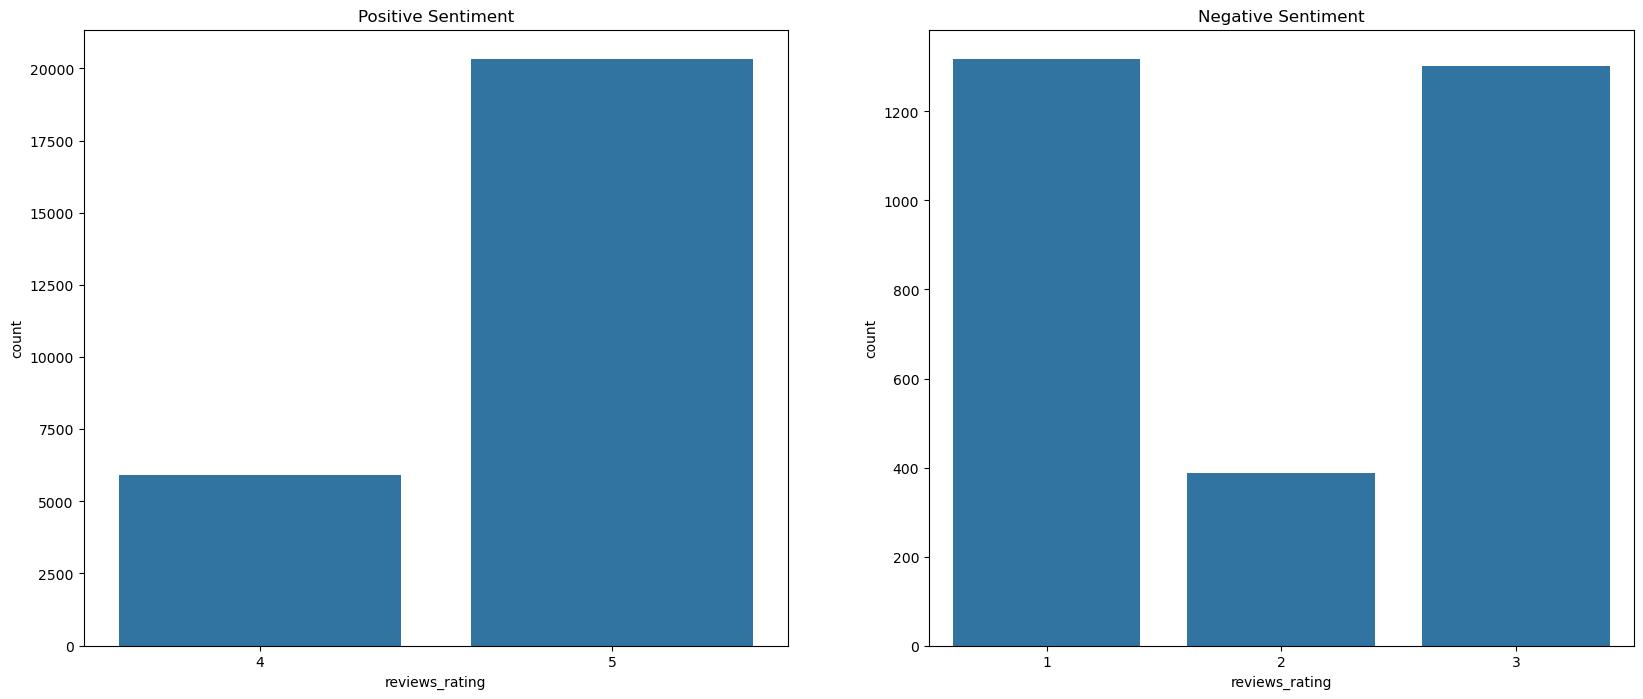

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.title.set_text("Positive Sentiment")
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 1], ax=ax1)
ax2.title.set_text("Negative Sentiment")
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 0], ax=ax2)
plt.show()

In [42]:
round(ebuss_df_clean_updated.user_sentiment.value_counts(normalize=True) * 100, 2)

user_sentiment
1    89.71
0    10.29
Name: proportion, dtype: float64

### **Observations - user_sentiment**
- There was some incorrect user_sentiment which was corrected by providing the right value for user sentiment
- user_sentiment is skewed - 89.7% positive
- Rows with 1-3 rating is given negative user_sentiment
- Rows with 4 and above rating is given positive user_sentiment

### **Understand the brand column**

Brand distribution with respect to user sentiment

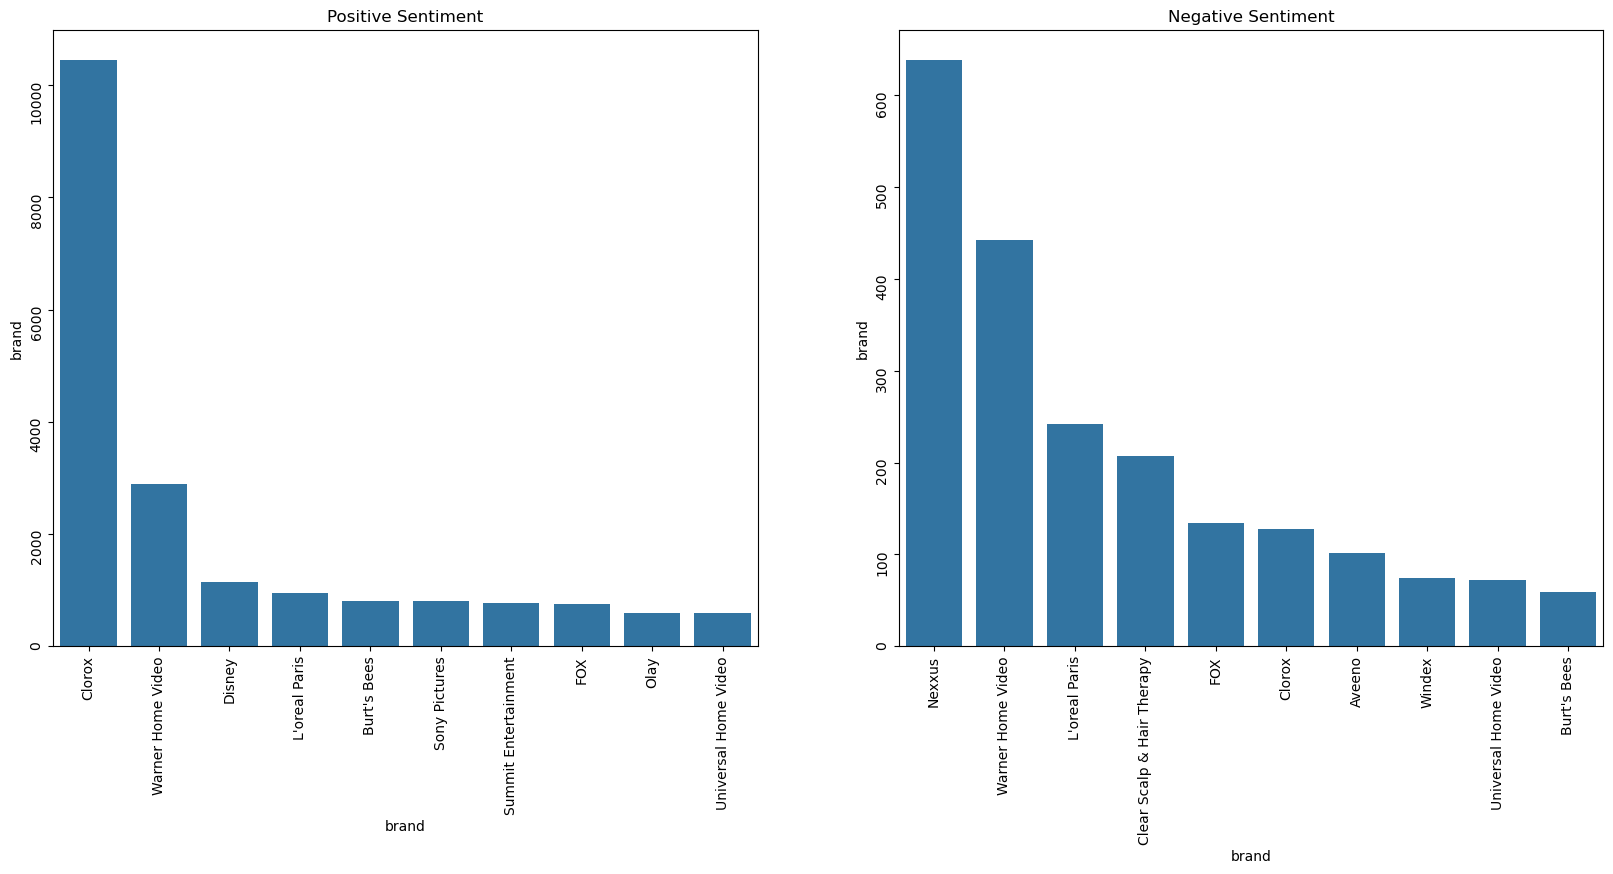

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
# plt.xticks(rotation=90)

# Filter the top 10 brands among the positive sentiments
sns.barplot(data=ebuss_df_clean_updated[ebuss_df_clean_updated['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10], ax=ax1)
ax1.tick_params(labelrotation=90)
ax1.title.set_text("Positive Sentiment")

sns.barplot(data=ebuss_df_clean_updated[ebuss_df_clean_updated['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:10], ax=ax2)
ax2.title.set_text("Negative Sentiment")
ax2.tick_params(labelrotation=90)

plt.show()

# Filter the top 10 brands among the positive sentiments
# ebuss_df_clean_updated[ebuss_df_clean_updated['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10]


### **Observation - Analysing features**
- Clorox brand has the maximum positive reviews
- Nexxus brand has the maximum negative reviews
- `89.71%` rows contains positive sentiment and just `10.29%` rows contains negative sentiment - **This could result in class imbalance problem**

#### Item level user sentiment

In [44]:
def filter_products(df, productId, pos=1):
    review_count = df[(df.id==productId) & (df.user_sentiment==pos)]['brand'].count()
    return review_count

In [45]:
#group the dataframe by product id and view the # of pos review / neg reviews count
ebuss_custom =  ebuss_df_clean_updated.groupby('id', as_index=False)['user_sentiment'].count()
ebuss_custom["pos_review_count"] =  ebuss_custom.id.apply(lambda id: filter_products(ebuss_df_clean_updated, id, 1))
ebuss_custom["neg_review_count"] =  ebuss_custom.id.apply(lambda id: filter_products(ebuss_df_clean_updated, id, 0))

In [46]:
ebuss_custom.sort_values(by=['user_sentiment'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count
81,AVpf3VOfilAPnD_xjpun,8545,8447,98
165,AVpfPaoqLJeJML435Xk9,3325,2883,442
142,AVpfJP1C1cnluZ0-e3Xy,2039,2009,30
184,AVpfW8y_LJeJML437ySW,1186,944,242
173,AVpfRTh1ilAPnD_xYic2,1142,1092,50
90,AVpf63aJLJeJML43F__Q,873,814,59
74,AVpf0eb2LJeJML43EVSt,845,812,33
35,AVpe41TqilAPnD_xQH3d,757,631,126
211,AVpfm8yiLJeJML43AYyu,685,46,639
79,AVpf2tw1ilAPnD_xjflC,669,645,24


**Sorted based on positive user_sentiments received**

In [47]:
ebuss_custom.sort_values(by=['pos_review_count'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count
81,AVpf3VOfilAPnD_xjpun,8545,8447,98
165,AVpfPaoqLJeJML435Xk9,3325,2883,442
142,AVpfJP1C1cnluZ0-e3Xy,2039,2009,30
173,AVpfRTh1ilAPnD_xYic2,1142,1092,50
184,AVpfW8y_LJeJML437ySW,1186,944,242
90,AVpf63aJLJeJML43F__Q,873,814,59
74,AVpf0eb2LJeJML43EVSt,845,812,33
79,AVpf2tw1ilAPnD_xjflC,669,645,24
35,AVpe41TqilAPnD_xQH3d,757,631,126
24,AV1l8zRZvKc47QAVhnAv,634,597,37


**Sorted based on negative user_sentiments received**

In [48]:
ebuss_custom.sort_values(by=['neg_review_count'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count
211,AVpfm8yiLJeJML43AYyu,685,46,639
165,AVpfPaoqLJeJML435Xk9,3325,2883,442
184,AVpfW8y_LJeJML437ySW,1186,944,242
161,AVpfOmKwLJeJML435GM7,370,163,207
35,AVpe41TqilAPnD_xQH3d,757,631,126
164,AVpfPPkEilAPnD_xX3cP,270,169,101
81,AVpf3VOfilAPnD_xjpun,8545,8447,98
3,AV1YGDqsGV-KLJ3adc-O,348,274,74
38,AVpe59io1cnluZ0-ZgDU,668,596,72
90,AVpf63aJLJeJML43F__Q,873,814,59


**Products with only positive sentiment**

In [49]:
#sort the product by sentiment % - postive reviews / total number of reviews
ebuss_custom['sentiment %'] = np.round((ebuss_custom['pos_review_count']/ebuss_custom['user_sentiment'])*100,2)
ebuss_custom.sort_values(by=['sentiment %', 'pos_review_count'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
49,AVpe6FpaLJeJML43yBuP,68,68,0,100.0
8,AV1Ymf_rglJLPUi8II2v,34,34,0,100.0
73,AVpf0YhQLJeJML43ETff,34,34,0,100.0
170,AVpfQtEm1cnluZ0-hUpe,27,27,0,100.0
193,AVpfe3On1cnluZ0-lgn5,20,20,0,100.0
141,AVpfIvbgLJeJML433Kph,17,17,0,100.0
54,AVpe7GIELJeJML43yZfu,15,15,0,100.0
31,AVpe-ltS1cnluZ0-bL8w,13,13,0,100.0
227,AVpfrfHF1cnluZ0-pRai,13,13,0,100.0
107,AVpfBpnEilAPnD_xTUBx,11,11,0,100.0


**Products with only positive sentiment**

In [50]:
#sort the product by sentiment % - postive reviews / total number of reviews
ebuss_custom['sentiment %'] = np.round((ebuss_custom['neg_review_count']/ebuss_custom['user_sentiment'])*100,2)
ebuss_custom.sort_values(by=['sentiment %', 'neg_review_count'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
30,AVpe-YAL1cnluZ0-bHGh,1,0,1,100.0
34,AVpe4-GPLJeJML43xmuY,1,0,1,100.0
45,AVpe625_ilAPnD_xQ4SP,1,0,1,100.0
46,AVpe6C3WLJeJML43yApY,1,0,1,100.0
61,AVpe8q4T1cnluZ0-afct,1,0,1,100.0
111,AVpfC3KoLJeJML431KRR,1,0,1,100.0
121,AVpfDflP1cnluZ0-c5RJ,1,0,1,100.0
124,AVpfE7puilAPnD_xUcCW,1,0,1,100.0
129,AVpfF7k8ilAPnD_xUyWf,1,0,1,100.0
137,AVpfHZMxLJeJML432tfs,1,0,1,100.0


# **Task 2: Text Processing**

### **Helper functions**

In [51]:
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])

# Preprocesses a given text document.
#   Args:
#     document (str): The input text document.
#   Returns:
#     str: The preprocessed text document.
#   This function performs the following preprocessing steps:
#     1. **Lowercasing:** Converts all characters to lowercase.
#     2. **Punctuation and Number Removal:** Removes punctuation marks and words containing numbers.
#     3. **Tokenization:** Splits the text into individual words.
#     4. **Stop Word Removal:** Removes common stop words (e.g., "the," "and," "of").
#     5. **Short Word Removal:** Removes words with one or fewer characters.
#     6. **Joining:** Joins the processed words back into a single string.
def preprocess(document):
  # 1. Change the document to lower case
  document = document.lower()

  # 2. Remove punctuation and words containing numbers
  document = re.sub("[^\sA-z]","",document)

  negative_words = {
        "no",
        "not",
        "none",
        "neither",
        "never",
        "nobody",
        "nothing",
        "nowhere",
        "doesn't",
        "isn't",
        "wasn't",
        "shouldn't",
        "won't",
        "can't",
        "couldn't",
        "don't",
        "haven't",
        "hasn't",
        "hadn't",
        "aren't",
        "weren't",
        "wouldn't",
        "daren't",
        "needn't",
        "didn't",
        "without",
        "against",
        "negative",
        "deny",
        "reject",
        "refuse",
        "decline",
        "unhappy",
        "sad",
        "miserable",
        "hopeless",
        "worthless",
        "useless",
        "futile",
        "disagree",
        "oppose",
        "contrary",
        "contradict",
        "disapprove",
        "dissatisfied",
        "objection",
        "unsatisfactory",
        "unpleasant",
        "regret",
        "resent",
        "lament",
        "mourn",
        "grieve",
        "bemoan",
        "despise",
        "loathe",
        "detract",
        "abhor",
        "dread",
        "fear",
        "worry",
        "anxiety",
        "sorrow",
        "gloom",
        "melancholy",
        "dismay",
        "disheartened",
        "despair",
        "dislike",
        "aversion",
        "antipathy",
        "hate",
        "disdain"
    }

  # 3. Tokenize the words
  words = word_tokenize(document)

  new_stop_set = stop_words = set(stopwords.words('english')) - set(negative_words)
  # 4. Remove the stop words
  words = [word for word in words if word not in new_stop_set]

  # 5. Remove words with 0 or 1 letter
  words = [w for w in words if len(w) > 1]

  # 6. Join the processed words back into a single string
  document = " ".join(words)
  return(document)



# Lemmatizes a given text using spaCy.
# Args:
# text (str): The input text to be lemmatized.
# Returns:
# str: The lemmatized text.
def lemmatize_text(text):
    sent = []
    
    # Process the text using spaCy's NLP pipeline
    doc = nlp(text) 
    for token in doc:
        # Append the lemma of each token to the sentence list
        sent.append(token.lemma_)
    
    # Join the lemmatized tokens into a single string and return the result
    return " ".join(sent)



# Gets the top N most frequent n-grams from a given corpus.
# Args:
#     corpus (list): A list of text documents.
#     n_gram_range (int): The range of n-grams to consider.
#     n (int, optional): The number of top n-grams to return. Defaults to None, which returns all n-grams.
# Returns:
#     list: A list of tuples, where each tuple contains an n-gram and its frequency.
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    # Create a CountVectorizer to count the frequency of n-grams
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    
    # Transform the corpus into a bag-of-words representation
    bag_of_words = vec.transform(corpus)

    # Sum the frequencies of each n-gram across all documents
    sum_words = bag_of_words.sum(axis=0)    # --1: Calculate the sum of frequencies for each n-gram 
    # print("--1",sum_words)

    # Get the first word and its index to break the loop
    for word, idx in vec.vocabulary_.items():
        break

    # Create a list of tuples, where each tuple contains an n-gram and its frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort the list of tuples by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    # Return the top N n-grams
    return words_freq[:n]

### **Preprocessing the ReviewsTitle and ReviewText**
- Add a new column `reviews_preprocess_text` with value join of `reviews_title` and `reviews_text`

**Preprocessing**
- Remove punctuation
- Remove stopwords
- Remove words with less than 2 letters

**Lematization**
- Add a new column `reviews_complete_text`
- Reduce words to it's lemma form

In [52]:
ebuss_df_clean_updated["reviews_preprocess_text"] = ebuss_df_clean_updated[['reviews_title', 'reviews_text']].agg(' '.join, axis=1).str.lstrip('. ')

# Preprocessing
ebuss_df_clean_updated["reviews_preprocess_text"] = ebuss_df_clean_updated["reviews_preprocess_text"].apply(preprocess)

# Lematization
ebuss_df_clean_updated["reviews_complete_text"] = ebuss_df_clean_updated["reviews_preprocess_text"].apply(lemmatize_text)

In [53]:
ebuss_df_clean_updated.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_preprocess_text,reviews_complete_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",others,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphors crazy,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,good good flavor review collected part promotion,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor.,Good,dorothy w,1,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",others,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,rebecca,0,disappointed read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean not pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant less money less mess,disappoint read review look buy one couple lubricant ultimately disappointed do not even live review read starter neither boyfriend could notice sort enhance captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean not pleasant especially since lack captivate sensation expect I m disappoint pay much lube will not use could use normal personal lubricant less money less mess
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",others,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,irritation husband bought gel us gel caused irritation felt like burning skin wouldnt recommend gel,irritation husband buy gel us gel cause irritation feel like burn skin would not recommend gel


### Save the Preproced the dataframe using pickel

In [54]:
save_object(ebuss_df_clean_updated, 'preprocessed-dataframe')


# **Task 3: Feature Extraction**

Create WordCloud to check on Top 50 words

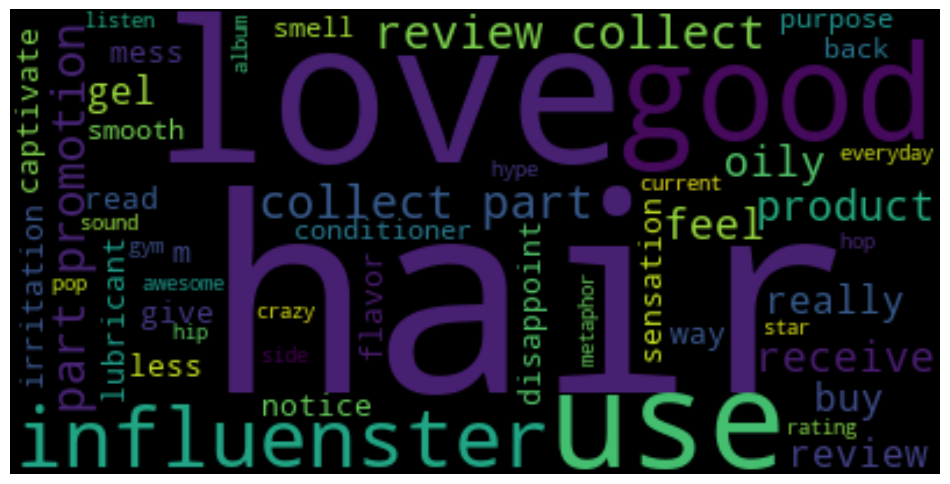

In [55]:
wordcloud = WordCloud(max_words=50, random_state=42)
wordcloud.generate(str(ebuss_df_clean_updated['reviews_complete_text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [56]:
words_per_review = ebuss_df_clean_updated['reviews_complete_text'].apply(lambda x: len(x.split(" ")))
print('Average words per Review:', round(words_per_review.mean(),2))

Average words per Review: 19.9


#### Top 10 words in the unigram frequency

In [57]:
common_words = get_top_n_ngram(ebuss_df_clean_updated['reviews_complete_text'], 1, 10)
pd.DataFrame(common_words)

,0,1
0,great,14689
1,use,13353
2,love,12845
3,product,12438
4,movie,10837
5,review,9410
6,good,8887
7,collect,8770
8,promotion,8748
9,wipe,8375


#### Top 10 words in the bigram frequency

In [58]:
common_words = get_top_n_ngram(ebuss_df_clean_updated['reviews_complete_text'], 2, 10)
pd.DataFrame(common_words)

,0,1
0,review collect,8743
1,collect promotion,8743
2,clorox wipe,2846
3,great product,1995
4,great movie,1771
5,easy use,1566
6,love clorox,1233
7,love product,1177
8,use clorox,1108
9,good movie,1083


#### Top 10 words in the trigram frequency

In [59]:
common_words = get_top_n_ngram(ebuss_df_clean_updated['reviews_complete_text'], 3, 10)
pd.DataFrame(common_words)

,0,1
0,review collect promotion,8743
1,love clorox wipe,608
2,use clorox wipe,559
3,clorox disinfecting wipe,511
4,clean review collect,444
5,product review collect,430
6,use review collect,363
7,great product love,287
8,great movie great,267
9,clorox wipe love,254


### **Observations**
- Highlighted the most occuring words with word cloud
- The average word count per review is 19.6%
- We have extracted all the 1-gram, 2-gram, and 3-gram words

### **Feature extraction & Input and output variable seperation**

In [60]:
# Creating TF-IDF vectorizer, for model building
# Considering all unigram, bigram, trigram words
vectorizer = TfidfVectorizer(max_df=0.95,min_df=5,
                             stop_words='english',
                             tokenizer= word_tokenize,
                             ngram_range=(1,3))

In [61]:
# Fitting the TF-IDF vectorizer on the training set
X_tfidf = vectorizer.fit_transform(ebuss_df_clean_updated['reviews_complete_text'])
y = ebuss_df_clean_updated['user_sentiment']

#### Save Vectorizer Object

In [62]:
# Save Vectorizer Object
save_object(vectorizer, 'tfidf-vectorizer')

In [63]:
print(X_tfidf.shape)
print(y.shape)

(29255, 20671)
(29255,)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state=42, test_size=0.2)
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)

X_train shape = (23404, 20671)
X_test shape = (5851, 20671)
y_train shape = (23404,)
y_test shape = (5851,)


### **Implementing SMOTE as user_sentiment is imbalanced**

In [65]:
count = Counter(y_train)
print('Before Applying SMOTE:',count)

sm = SMOTE(random_state = 42)

# transform the dataset
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train.ravel())

count = Counter(y_train_sm)
print('After Applying SMOTE:',count)

Before Applying SMOTE: Counter({1: 20976, 0: 2428})
After Applying SMOTE: Counter({1: 20976, 0: 20976})


# **Task 4: Model Building**

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Helper models

In [67]:
#-----------------------------------------------------------------------------------------------------------------------#

#   This class provides a factory pattern for creating and evaluating machine learning models.
#   It simplifies the process of training, testing, and evaluating models by providing a consistent interface.
class ModelFactory:
  
  # Initializes the ModelFactory instance.
  # Args:
  #   model: The machine learning model object to be trained and evaluated.
  #   model_name: A string representing the name of the model.
  #   X_train: The training data features.
  #   y_train: The training data target labels.
  #   X_test: The testing data features.
  #   y_test: The testing data target labels.
  def __init__(self,model, model_name, X_train,y_train,X_test,y_test):
    self.model = model
    self.model_name = model_name
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.train_metrics = []
    self.test_metrics = []

  # Trains the model on the provided training data.
  # Returns:
  #   The model's predictions on the training data.
  def train(self):
    self.model.fit(self.X_train,self.y_train)
    return self.model.predict(self.X_train)

  # Evaluates the model on the provided testing data.
  # Returns:
  #   The model's predictions on the testing data.
  def test(self):
    return self.model.predict(self.X_test)

  # Sets the testing data for the model.
  # This method allows you to update the testing data after the ModelFactory is initialized.
  # Args:
  #   test_data: The new testing data features.
  # This API is added for model load cases
  def set_test_data(self,test_data):
    self.X_test = test_data


  # Predicts on the testing data using the trained model.

  # Returns:
  #   The model's predictions on the testing data.
  def predict(self):
    return self.model.predict(self.X_test)


  # Calculates and stores various evaluation metrics for the training data.
  # Creates confusion metrics and roc_curve
  # Args:
  #   y_pred: The model's predictions on the training data.
  def evaluate_metrics_train(self,y_pred):
    accuracy = round(accuracy_score(self.y_train, y_pred),2)
    precision = round(precision_score(self.y_train,y_pred),2)
    recall = round(recall_score(self.y_train,y_pred),2)
    f1 = round(f1_score(self.y_train,y_pred),2)
    auc_score = round(roc_auc_score(self.y_train,y_pred),2)
    self.train_metrics.append(accuracy)
    self.train_metrics.append(precision)
    self.train_metrics.append(recall)
    self.train_metrics.append(f1)
    self.train_metrics.append(auc_score)

    print("Train Data Metrics - ", self.model_name)
    
    print("*"*20)
    print("*"*20)
    print("Accuracy:", self.train_metrics[0])
    print("Precision:", self.train_metrics[1])
    print("Recall:", self.train_metrics[2])
    print("F1 Score:", self.train_metrics[3])
    print("AUC Score:", self.train_metrics[4])
    
    print("*"*20)
    print("*"*20)
    self.get_confusion_matrix_train(y_pred)

    print("*"*20)
    print("*"*20)
    self.plot_roc_curve(self.y_train, y_pred)
    return

  # Calculates and stores various evaluation metrics for the testing data.
  # Creates confusion metrics and roc_curve
  # Args:
  #   y_pred: The model's predictions on the testing data.
  def evaluate_metrics_test(self,y_pred):
    accuracy = round(accuracy_score(self.y_test, y_pred),2)
    precision = round(precision_score(self.y_test,y_pred),2)
    recall = round(recall_score(self.y_test,y_pred),2)
    f1 = round(f1_score(self.y_test,y_pred),2)
    auc_score = round(roc_auc_score(self.y_test,y_pred),2)

    self.test_metrics.append(accuracy)
    self.test_metrics.append(precision)
    self.test_metrics.append(recall)
    self.test_metrics.append(f1)
    self.test_metrics.append(auc_score)
    

    print("Test Data Metrics - ", self.model_name)
    
    print("*"*20)
    print("*"*20)
    print("Accuracy:", self.test_metrics[0])
    print("Precision:", self.test_metrics[1])
    print("Recall:", self.test_metrics[2])
    print("F1 Score:", self.test_metrics[3])
    print("AUC Score:", self.test_metrics[4])
    
    print("*"*20)
    print("*"*20)
    self.get_confusion_matrix_test(y_pred)

    print("*"*20)
    print("*"*20)
    self.plot_roc_curve(self.y_test, y_pred)
    return

  # Generates and plots the confusion matrix for the training data.
  # This method calculates the confusion matrix using the `confusion_matrix` function
  # from scikit-learn and then calls the `plot_confusion_matrix` method to visualize it.
  # Args:
  #   y_pred: The model's predictions on the training data.
  def get_confusion_matrix_train(self, y_pred):
    confusion_mat = confusion_matrix(self.y_train, y_pred)
    self.plot_confusion_matrix(confusion_mat,[0,1])
    return


  # Generates and plots the confusion matrix for the testing data.
  # This method is similar to `get_confusion_matrix_train` but uses the testing data
  # (self.y_test) to calculate the confusion matrix.
  # Args:
  #   y_pred: The model's predictions on the testing data.
  def get_confusion_matrix_test(self, y_pred):
    confusion_mat = confusion_matrix(self.y_test, y_pred)
    self.plot_confusion_matrix(confusion_mat,[0,1])
    return

  # Visualizes the confusion matrix using Seaborn's heatmap.
  # This method takes the confusion matrix data and labels as input and creates a heatmap
  # using Seaborn. It sets the title, labels, and formatting for the plot.
  # Args:
  #   data: The confusion matrix data.
  #   labels: The labels for the confusion matrix (e.g., class labels).
  def plot_confusion_matrix(self, data, labels):
      sns.set(color_codes=True)
      plt.title("Confusion Matrix")
      ax = sns.heatmap(data, annot=True, cmap="Blues", fmt=".1f")
      ax.set_xticklabels(labels)
      ax.set_yticklabels(labels)
      ax.set(ylabel="True Values", xlabel="Predicted Values")
      plt.show()
      return

  # Returns the list of evaluation metrics for the training data.
  # This method simply returns the `self.train_metrics` list, which stores the calculated
  # metrics (accuracy, precision, etc.) for the training data.
  def get_train_metrics(self):
    return self.train_metrics


  # Returns the list of evaluation metrics for the testing data.
  # This method is similar to `get_train_metrics` but returns the `self.test_metrics` list
  # containing the metrics for the testing data.
  def get_test_metrics(self):
    return self.test_metrics


  # Plots the Receiver Operating Characteristic (ROC) curve for the model.
  # This method calculates the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under 
  # the Curve (AUC) using scikit-learn's `roc_curve` and `roc_auc_score` functions. It then creates
  # a plot of the ROC curve using Matplotlib.
  # Args:
  #   y_actual: The ground truth labels.
  #   y_pred: The model's predictions.
  def plot_roc_curve(self, y_actual, y_pred):
        fpr, tpr, _ = metrics.roc_curve(y_actual,  y_pred)
        auc = metrics.roc_auc_score(y_actual, y_pred)
        plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
        plt.legend(loc=4)
        plt.show()
  
#-----------------------------------------------------------------------------------------------------------------------#


# This class encapsulates a Logistic Regression model, leveraging the ModelFactory class for training, testing, and evaluation.
# Attributes:
#     X_train (array-like): The training data features.
#     y_train (array-like): The training data target labels.
#     X_test (array-like): The testing data features.
#     y_test (array-like): The testing data target labels.
#     model_name (str): The name of the model.
#     lr_obj (ModelFactory): An instance of the ModelFactory class for model operations.
class LogisticRegressionModel:
    
    # Initializes the LogisticRegressionModel instance.
    # Args:
    #     model_name (str): The name of the model.
    #     X_train (array-like): The training data features.
    #     y_train (array-like): The training data target labels.
    #     X_test (array-like): The testing data features.
    #     y_test (array-like): The testing data target labels.
    def __init__(self,model_name, X_train, y_train, X_test, y_test):
      self.X_train = X_train
      self.y_train = y_train
      self.X_test = X_test
      self.y_test = y_test
      self.model_name = model_name

      lr = LogisticRegression(random_state=42)
      self.lr_obj = ModelFactory(lr, self.model_name, self.X_train, self.y_train, self.X_test, self.y_test)
    

    # Trains the Logistic Regression model and evaluates its performance on the training data.
    # This method trains the model using the ModelFactory's `train` method, generates predictions on the training data,
    # and then evaluates the model's performance using the `evaluate_metrics_train` method of the ModelFactory.
    def evaluate_train(self):
        y_train_pred = self.lr_obj.train()
        self.lr_obj.evaluate_metrics_train(y_train_pred)


    # Evaluates the Logistic Regression model on the testing data.
    # This method generates predictions on the testing data using the ModelFactory's `test` method and
    # then evaluates the model's performance using the `evaluate_metrics_test` method of the ModelFactory.
    def evaluate_test(self):
        y_test_pred = self.lr_obj.test()
        self.lr_obj.evaluate_metrics_test(y_test_pred)


#-----------------------------------------------------------------------------------------------------------------------#



# This class encapsulates a Naive Bayes Regression model, leveraging the ModelFactory class for training, testing, and evaluation.
# Attributes:
#     X_train (array-like): The training data features.
#     y_train (array-like): The training data target labels.
#     X_test (array-like): The testing data features.
#     y_test (array-like): The testing data target labels.
#     model_name (str): The name of the model.
#     nb_obj (ModelFactory): An instance of the ModelFactory class for model operations.
class NaiveBayesRegressionModel:
    
    # Initializes the NaiveBayesRegressionModel instance.
    # Args:
    #     model_name (str): The name of the model.
    #     X_train (array-like): The training data features.
    #     y_train (array-like): The training data target labels.
    #     X_test (array-like): The testing data features.
    #     y_test (array-like): The testing data target labels.
    def __init__(self,model_name, X_train, y_train, X_test, y_test):
      self.X_train = X_train
      self.y_train = y_train
      self.X_test = X_test
      self.y_test = y_test
      self.model_name = model_name

      nb = MultinomialNB()
      self.nb_obj = ModelFactory(nb, self.model_name, self.X_train, self.y_train, self.X_test, self.y_test)     


    # Trains the Naive Bayes Regression model and evaluates its performance on the training data.
    # This method trains the model using the ModelFactory's `train` method, generates predictions on the training data,
    # and then evaluates the model's performance using the `evaluate_metrics_train` method of the ModelFactory.
    def evaluate_train(self):
        y_train_pred = self.nb_obj.train()
        self.nb_obj.evaluate_metrics_train(y_train_pred)

    # Evaluates the Naive Bayes Regression model on the testing data.
    # This method generates predictions on the testing data using the ModelFactory's `test` method and
    # then evaluates the model's performance using the `evaluate_metrics_test` method of the ModelFactory.
    def evaluate_test(self):
        y_test_pred = self.nb_obj.test()
        self.nb_obj.evaluate_metrics_test(y_test_pred) 
       

#-----------------------------------------------------------------------------------------------------------------------#



# This class encapsulates a XGBoost Regression Model, leveraging the ModelFactory class for training, testing, and evaluation.
# Attributes:
#     X_train (array-like): The training data features.
#     y_train (array-like): The training data target labels.
#     X_test (array-like): The testing data features.
#     y_test (array-like): The testing data target labels.
#     model_name (str): The name of the model.
#     xgb_c_obj (ModelFactory): An instance of the ModelFactory class for model operations.
class XGBoostRegressionModel:
    
    # Initializes the XGBoostRegressionModel instance.
    # Args:
    #     model_name (str): The name of the model.
    #     X_train (array-like): The training data features.
    #     y_train (array-like): The training data target labels.
    #     X_test (array-like): The testing data features.
    #     y_test (array-like): The testing data target labels.
    def __init__(self,model_name, X_train, y_train, X_test, y_test):
      self.X_train = X_train
      self.y_train = y_train
      self.X_test = X_test
      self.y_test = y_test
      self.model_name = model_name

      xgb_c = xgb.XGBClassifier(random_state=42, n_jobs=-1)
      self.xgb_c_obj = ModelFactory(xgb_c, self.model_name, self.X_train, self.y_train, self.X_test, self.y_test)


    # Trains the XGBoost Regression model and evaluates its performance on the training data.
    # This method trains the model using the ModelFactory's `train` method, generates predictions on the training data,
    # and then evaluates the model's performance using the `evaluate_metrics_train` method of the ModelFactory.
    def evaluate_train(self):
        y_train_pred = self.xgb_c_obj.train()
        self.xgb_c_obj.evaluate_metrics_train(y_train_pred)


    # Evaluates the XGBoost Regression model on the testing data.
    # This method generates predictions on the testing data using the ModelFactory's `test` method and
    # then evaluates the model's performance using the `evaluate_metrics_test` method of the ModelFactory.
    def evaluate_test(self):
        y_test_pred = self.xgb_c_obj.test()
        self.xgb_c_obj.evaluate_metrics_test(y_test_pred) 



#-----------------------------------------------------------------------------------------------------------------------#




# This class performs hyperparameter tuning for an XGBoost regression model and leverages the ModelFactory class for training, testing, and evaluation.
#   Attributes:
#       X_train (array-like): The training data features.
#       y_train (array-like): The training data target labels.
#       X_test (array-like): The testing data features.
#       y_test (array-like): The testing data target labels.
#       model_name (str): The name of the model.
#       xgb_hp_tuned_obj (ModelFactory): An instance of the ModelFactory class for the hyper-tuned XGBoost model.
class XGBoostRegressionHyperParameterModel:
    
    # Initializes the XGBoostRegressionHyperParameterModel instance.
    # Args:
    #     model_name (str): The name of the model.
    #     X_train (array-like): The training data features.
    #     y_train (array-like): The training data target labels.
    #     X_test (array-like): The testing data features.
    #     y_test (array-like): The testing data target labels.
    def __init__(self,model_name, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model_name = model_name

        param_grid_xgb={'learning_rate': [0.0001, 0.001, 0.01,0.1, 1], 'max_depth': [5, 8, 10, 13, 15, 18, 20],
                        'n_estimators': [1, 3, 5, 7]}
        gv_xgb_hp_tuned = GridSearchCV(cv=5, estimator=xgb.XGBClassifier(random_state=42, n_jobs=-1),
                                param_grid=param_grid_xgb, verbose=1)
        xgb_hp_tuned = gv_xgb_hp_tuned.fit(X_train, y_train).best_estimator_
        self.xgb_hp_tuned_obj = ModelFactory(xgb_hp_tuned, self.model_name, self.X_train, self.y_train, self.X_test, self.y_test)


    # Trains the hyper-tuned XGBoost model and evaluates its performance on the training data.
    # This method trains the tuned model using the ModelFactory's `train` method, generates predictions on the training data,
    # and then evaluates the model's performance using the `evaluate_metrics_train` method of the ModelFactory.
    def evaluate_train(self):
        y_train_pred = self.xgb_hp_tuned_obj.train()
        self.xgb_hp_tuned_obj.evaluate_metrics_train(y_train_pred)


    # Evaluates the hyper-tuned XGBoost model on the testing data.
    # This method generates predictions on the testing data using the ModelFactory's `test` method and
    # then evaluates the model's performance using the `evaluate_metrics_test` method of the ModelFactory.
    def evaluate_test(self):
        y_test_pred = self.xgb_hp_tuned_obj.test()
        self.xgb_hp_tuned_obj.evaluate_metrics_test(y_test_pred) 


#-----------------------------------------------------------------------------------------------------------------------#


# This class encapsulates a Random Forest Classifier Model, leveraging the ModelFactory class for training, testing, and evaluation.
# Attributes:
#     X_train (array-like): The training data features.
#     y_train (array-like): The training data target labels.
#     X_test (array-like): The testing data features.
#     y_test (array-like): The testing data target labels.
#     model_name (str): The name of the model.
#     rf_obj (ModelFactory): An instance of the ModelFactory class for model operations.
class RandomForestClassifierModel:
    
    # Initializes the RandomForestClassifierModel instance.
    # Args:
    #     model_name (str): The name of the model.
    #     X_train (array-like): The training data features.
    #     y_train (array-like): The training data target labels.
    #     X_test (array-like): The testing data features.
    #     y_test (array-like): The testing data target labels.
    def __init__(self,model_name, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model_name = model_name

        rf_classifer = RandomForestClassifier(random_state=42,n_jobs=-1, criterion="gini")
        self.rf_obj = ModelFactory(rf_classifer, self.model_name, self.X_train, self.y_train, self.X_test, self.y_test)


    # Trains the XGBoost Regression model and evaluates its performance on the training data.
    # This method trains the model using the ModelFactory's `train` method, generates predictions on the training data,
    # and then evaluates the model's performance using the `evaluate_metrics_train` method of the ModelFactory.
    def evaluate_train(self):
        y_train_pred = self.rf_obj.train()
        self.rf_obj.evaluate_metrics_train(y_train_pred)


    # Evaluates the Naive Bayes Regression model on the testing data.
    # This method generates predictions on the testing data using the ModelFactory's `test` method and
    # then evaluates the model's performance using the `evaluate_metrics_test` method of the ModelFactory.
    def evaluate_test(self):
        y_test_pred = self.rf_obj.test()
        self.rf_obj.evaluate_metrics_test(y_test_pred)


#-----------------------------------------------------------------------------------------------------------------------#


# This class performs hyperparameter tuning for a Random Forest Classifier model and leverages the ModelFactory class for training, testing, and evaluation.
# Attributes:
#     X_train (array-like): The training data features.
#     y_train (array-like): The training data target labels.
#     X_test (array-like): The testing data features.
#     y_test (array-like): The testing data target labels.
#     model_name (str): The name of the model.
#     rf_hp_tuned_obj (ModelFactory): An instance of the ModelFactory class for the hyper-tuned Random Forest Classifier model.
class RandomForestClassifierHyperParameterModel:
    
    # Initializes the RandomForestClassifierHyperParameterModel instance.
    # Args:
    #     model_name (str): The name of the model.
    #     X_train (array-like): The training data features.
    #     y_train (array-like): The training data target labels.
    #     X_test (array-like): The testing data features.
    #     y_test (array-like): The testing data target labels.
    def __init__(self,model_name, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model_name = model_name

        param_grid_rf = {'max_depth': [2, 3, 5, 10],
                 'min_samples_leaf': [5, 10, 20],
                  'n_estimators': [10, 25, 50, 100]}

        gv_rf_hp_tuned = GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42,n_jobs=-1, criterion="gini"),
                            param_grid=param_grid_rf, verbose=1)
        rf_hp_tuned = gv_rf_hp_tuned.fit(X_train, y_train).best_estimator_
        self.rf_hp_tuned_obj = ModelFactory(rf_hp_tuned, self.model_name, self.X_train, self.y_train, self.X_test, self.y_test)


    # Trains the hyper-tuned Random Forest Classifier model and evaluates its performance on the training data.
    # This method trains the tuned model using the ModelFactory's `train` method, generates predictions on the training data,
    # and then evaluates the model's performance using the `evaluate_metrics_train` method of the ModelFactory.
    def evaluate_train(self):
        y_train_pred = self.rf_hp_tuned_obj.train()
        self.rf_hp_tuned_obj.evaluate_metrics_train(y_train_pred)


    # Evaluates the hyper-tuned Random Forest Classifier model on the testing data.
    # This method generates predictions on the testing data using the ModelFactory's `test` method and
    # then evaluates the model's performance using the `evaluate_metrics_test` method of the ModelFactory.
    def evaluate_test(self):
        y_test_pred = self.rf_hp_tuned_obj.test()
        self.rf_hp_tuned_obj.evaluate_metrics_test(y_test_pred) 


#-----------------------------------------------------------------------------------------------------------------------#


# This class encapsulates a Decision Tree Model, leveraging the ModelFactory class for training, testing, and evaluation.
# Attributes:
#     X_train (array-like): The training data features.
#     y_train (array-like): The training data target labels.
#     X_test (array-like): The testing data features.
#     y_test (array-like): The testing data target labels.
#     model_name (str): The name of the model.
#     rf_obj (ModelFactory): An instance of the ModelFactory class for model operations.
class DecisionTreeClassifierModel:
    
    # Initializes the RandomForestClassifierModel instance.
    # Args:
    #     model_name (str): The name of the model.
    #     X_train (array-like): The training data features.
    #     y_train (array-like): The training data target labels.
    #     X_test (array-like): The testing data features.
    #     y_test (array-like): The testing data target labels.
    def __init__(self,model_name, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model_name = model_name

        dt_classifer = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)
        self.dt_obj = ModelFactory(dt_classifer, self.model_name, self.X_train, self.y_train, self.X_test, self.y_test)


    # Trains the decision tree model and evaluates its performance on the training data.
    # This method trains the model using the ModelFactory's `train` method, generates predictions on the training data,
    # and then evaluates the model's performance using the `evaluate_metrics_train` method of the ModelFactory.
    def evaluate_train(self):
        y_train_pred = self.dt_obj.train()
        self.dt_obj.evaluate_metrics_train(y_train_pred)


    # Evaluates the decision tree model on the testing data.
    # This method generates predictions on the testing data using the ModelFactory's `test` method and
    # then evaluates the model's performance using the `evaluate_metrics_test` method of the ModelFactory.
    def evaluate_test(self):
        y_test_pred = self.dt_obj.test()
        self.dt_obj.evaluate_metrics_test(y_test_pred)

### **1. Logistic Regression with SMOTE**

In [68]:
logit = LogisticRegressionModel("logistic_regression", X_train_sm, y_train_sm, X_test, y_test)

Train Data Metrics -  logistic_regression
********************
********************
Accuracy: 0.96
Precision: 0.97
Recall: 0.95
F1 Score: 0.96
AUC Score: 0.96
********************
********************


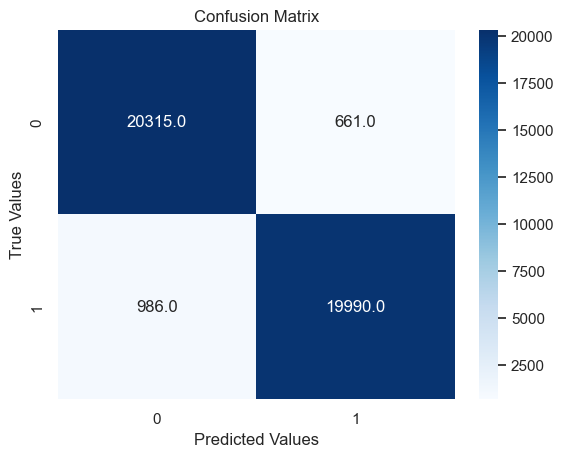

********************
********************


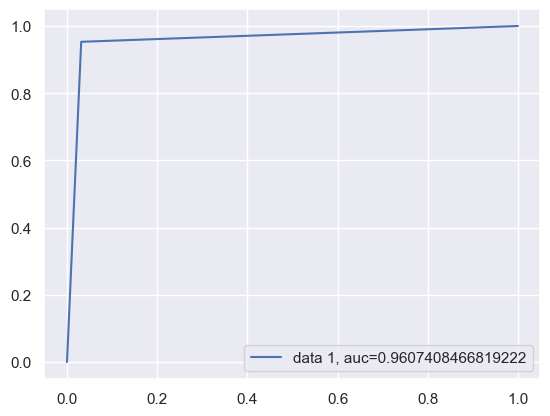

In [69]:
logit.evaluate_train()

Test Data Metrics -  logistic_regression
********************
********************
Accuracy: 0.92
Precision: 0.97
Recall: 0.93
F1 Score: 0.95
AUC Score: 0.85
********************
********************


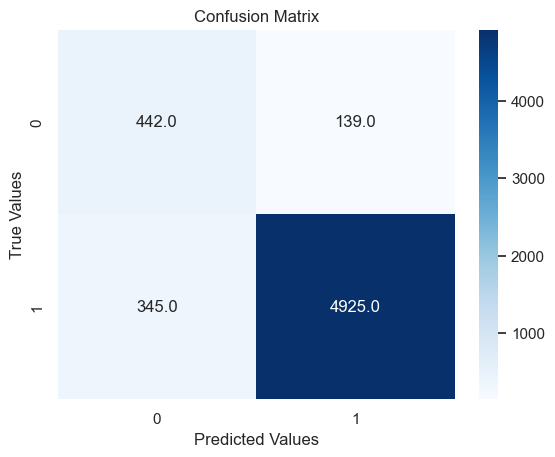

********************
********************


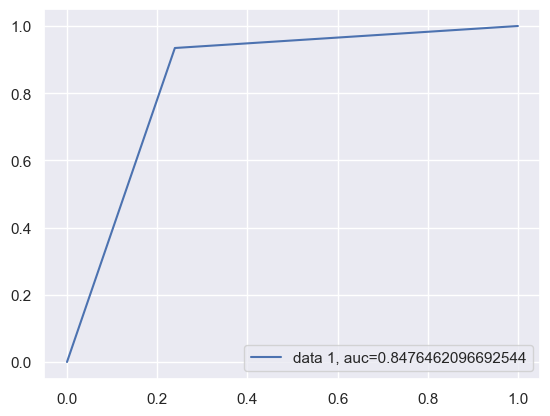

In [70]:
logit.evaluate_test()

#### Save logistic regression SMOTE model - `logistic_regression`

In [71]:
save_model(logit.lr_obj, logit.model_name)

### **2. Multinomial Naive Bayes**

In [72]:
multinomial_nb = NaiveBayesRegressionModel("multi_naive_bayes_regression", X_train_sm, y_train_sm, X_test, y_test)

Train Data Metrics -  multi_naive_bayes_regression
********************
********************
Accuracy: 0.91
Precision: 0.94
Recall: 0.88
F1 Score: 0.91
AUC Score: 0.91
********************
********************


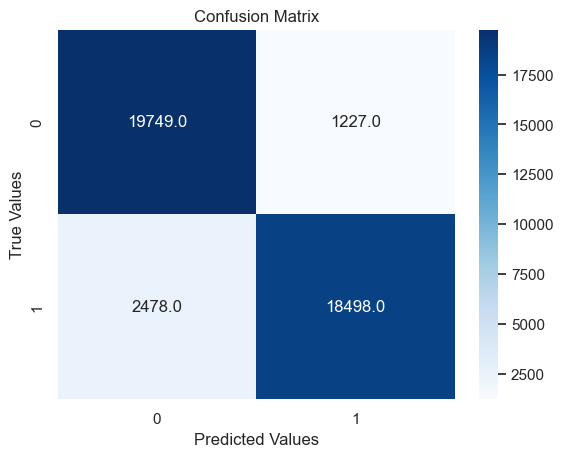

********************
********************


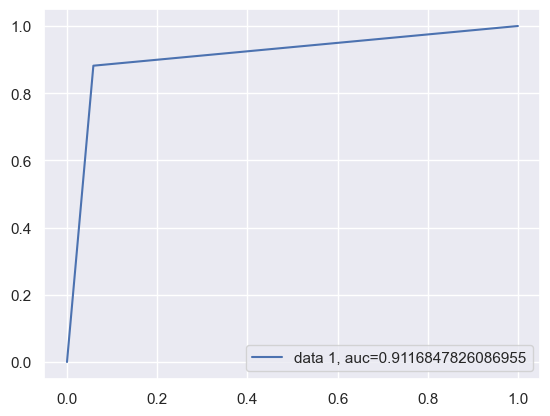

In [73]:
multinomial_nb.evaluate_train()

Test Data Metrics -  multi_naive_bayes_regression
********************
********************
Accuracy: 0.86
Precision: 0.98
Recall: 0.86
F1 Score: 0.92
AUC Score: 0.84
********************
********************


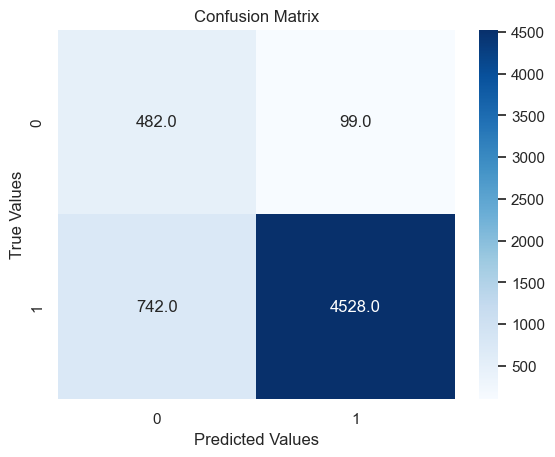

********************
********************


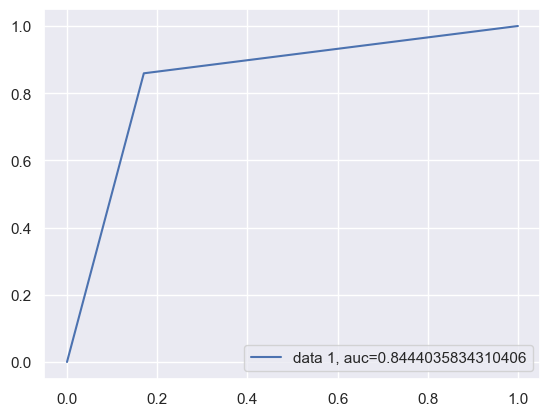

In [74]:
multinomial_nb.evaluate_test()

#### Save MNB model - `multi_naive_bayes_regression`

In [75]:
save_model(multinomial_nb.nb_obj, multinomial_nb.model_name)

### **3. XGBoost**

In [76]:
xgboost_classifier = XGBoostRegressionModel("xgboost_classifier", X_train_sm, y_train_sm, X_test, y_test)

Train Data Metrics -  xgboost_classifier
********************
********************
Accuracy: 0.96
Precision: 0.95
Recall: 0.98
F1 Score: 0.97
AUC Score: 0.96
********************
********************


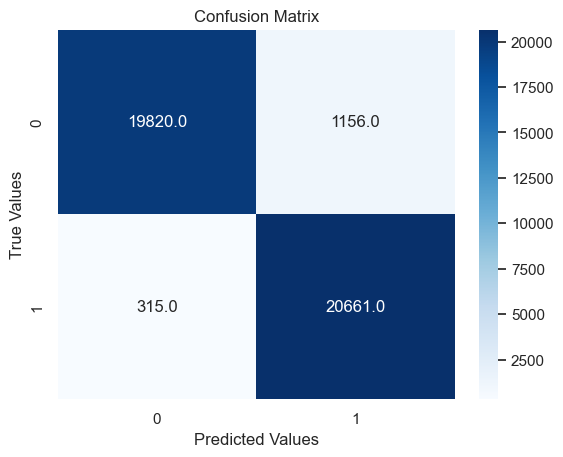

********************
********************


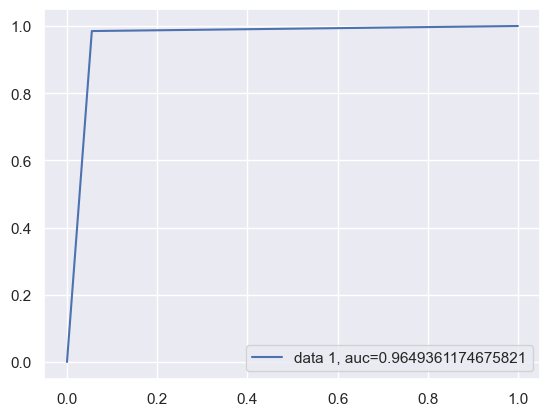

In [77]:
xgboost_classifier.evaluate_train()

Test Data Metrics -  xgboost_classifier
********************
********************
Accuracy: 0.93
Precision: 0.96
Recall: 0.97
F1 Score: 0.96
AUC Score: 0.79
********************
********************


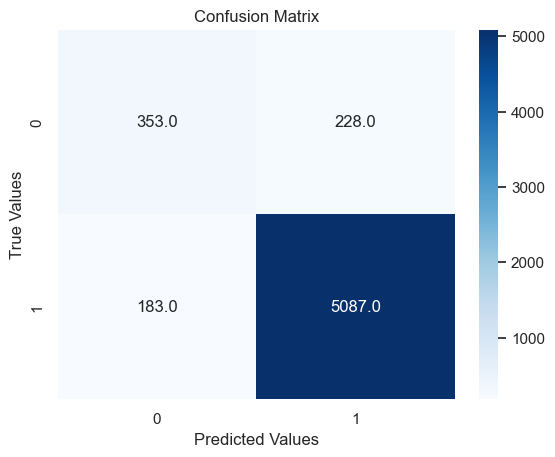

********************
********************


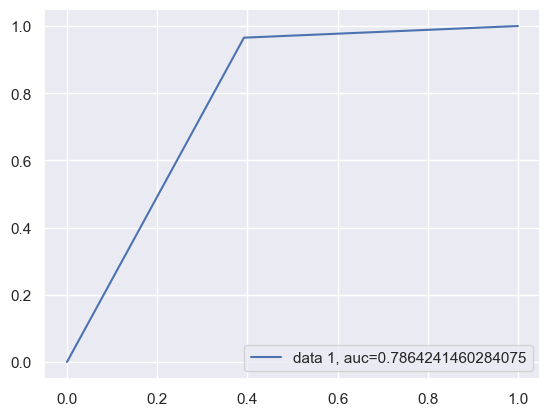

In [78]:
xgboost_classifier.evaluate_test()

In [79]:
save_model(xgboost_classifier.xgb_c_obj, xgboost_classifier.model_name)

### **4. Random Forest**

In [80]:
random_forest_classifier = RandomForestClassifierModel("random_forest_classifier", X_train_sm, y_train_sm, X_test, y_test)


Train Data Metrics -  random_forest_classifier
********************
********************
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC Score: 1.0
********************
********************


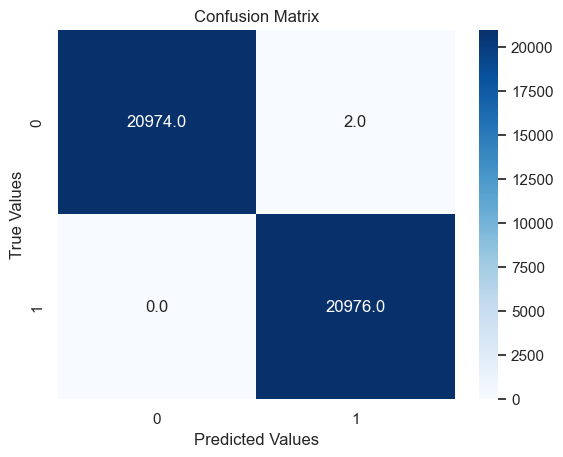

********************
********************


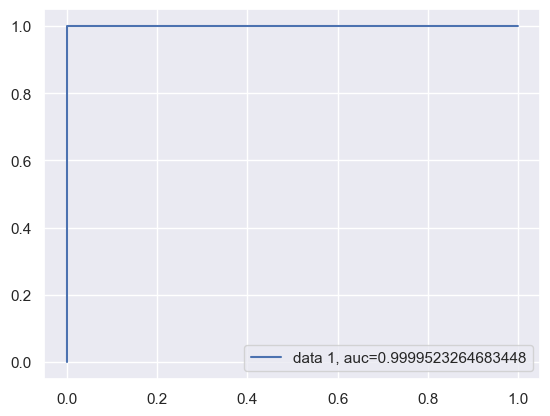

CPU times: user 18.2 s, sys: 1.85 s, total: 20.1 s
Wall time: 1.99 s


In [81]:
%%time
random_forest_classifier.evaluate_train()

Test Data Metrics -  random_forest_classifier
********************
********************
Accuracy: 0.94
Precision: 0.95
Recall: 0.98
F1 Score: 0.97
AUC Score: 0.77
********************
********************


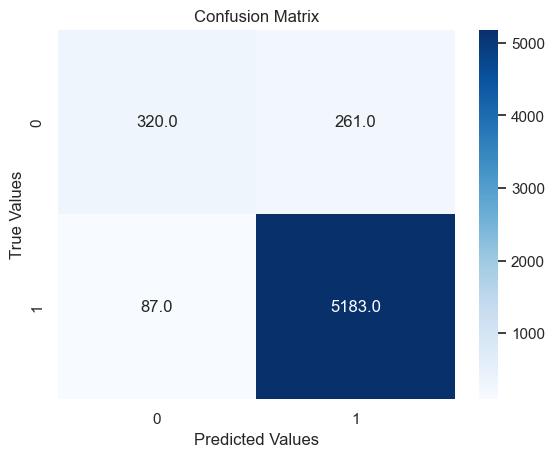

********************
********************


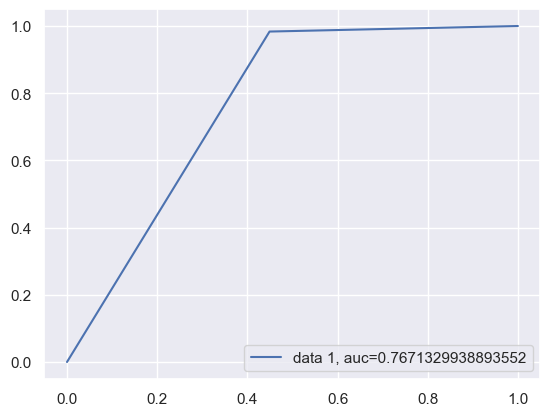

CPU times: user 618 ms, sys: 578 ms, total: 1.2 s
Wall time: 188 ms


In [82]:
%%time
random_forest_classifier.evaluate_test()

In [83]:
save_model(random_forest_classifier.rf_obj, random_forest_classifier.model_name)

### **5. Decision Tree**

In [84]:
dt_classifier = DecisionTreeClassifierModel("decision_tree_classifier_hp", X_train_sm, y_train_sm, X_test, y_test)

Train Data Metrics -  decision_tree_classifier_hp
********************
********************
Accuracy: 0.83
Precision: 0.92
Recall: 0.72
F1 Score: 0.81
AUC Score: 0.83
********************
********************


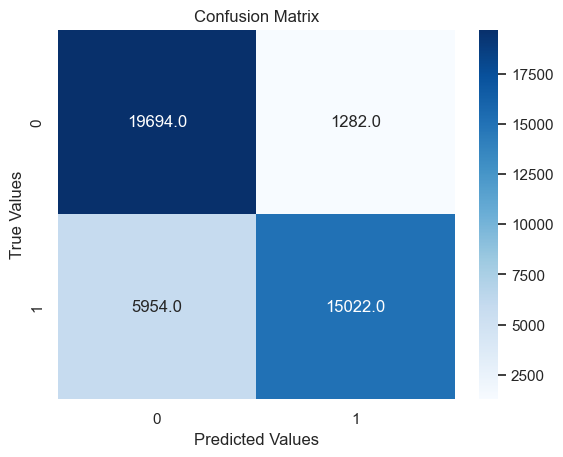

********************
********************


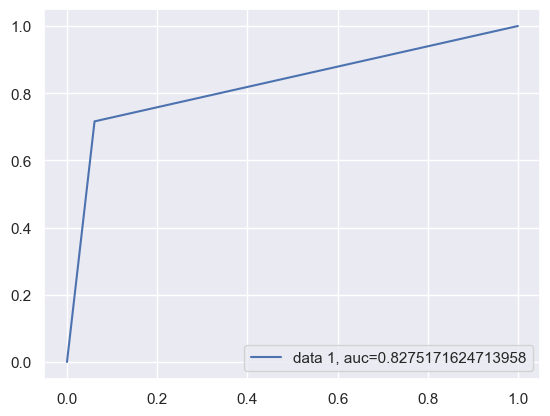

In [85]:
dt_classifier.evaluate_train()

Test Data Metrics -  decision_tree_classifier_hp
********************
********************
Accuracy: 0.72
Precision: 0.97
Recall: 0.71
F1 Score: 0.82
AUC Score: 0.77
********************
********************


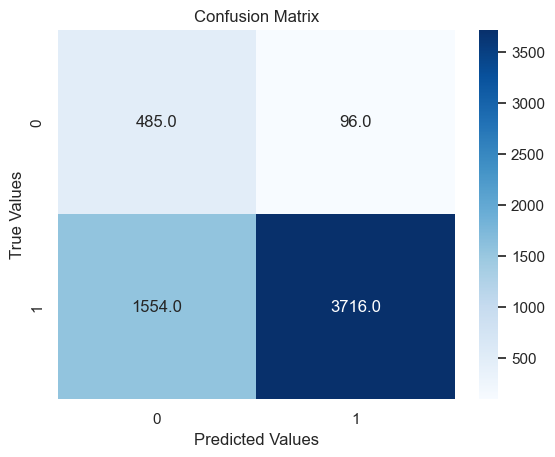

********************
********************


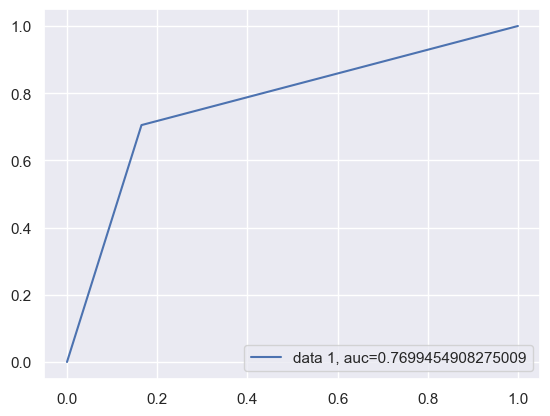

In [86]:
dt_classifier.evaluate_test()

In [87]:
save_model(dt_classifier.dt_obj, dt_classifier.model_name)

### **6. Random Forest HyperParameter**

In [88]:
random_forest_classifier_hp = RandomForestClassifierHyperParameterModel("random_forest_classifier_hp", X_train_sm, y_train_sm, X_test, y_test)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


Train Data Metrics -  random_forest_classifier_hp
********************
********************
Accuracy: 0.84
Precision: 0.79
Recall: 0.94
F1 Score: 0.86
AUC Score: 0.84
********************
********************


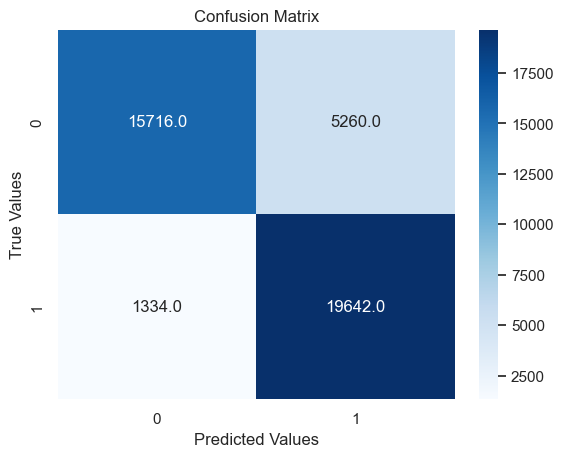

********************
********************


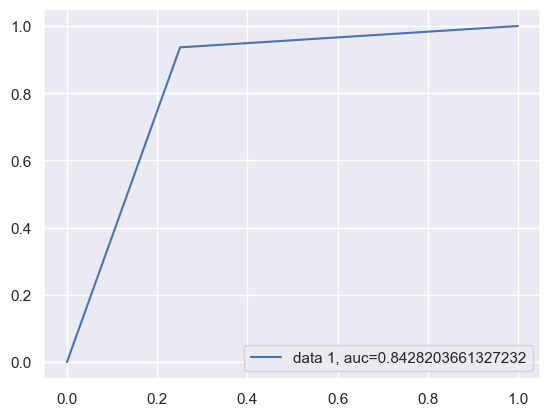

CPU times: user 1.69 s, sys: 66.2 ms, total: 1.76 s
Wall time: 408 ms


In [89]:
%%time
random_forest_classifier_hp.evaluate_train()

Test Data Metrics -  random_forest_classifier_hp
********************
********************
Accuracy: 0.89
Precision: 0.95
Recall: 0.93
F1 Score: 0.94
AUC Score: 0.73
********************
********************


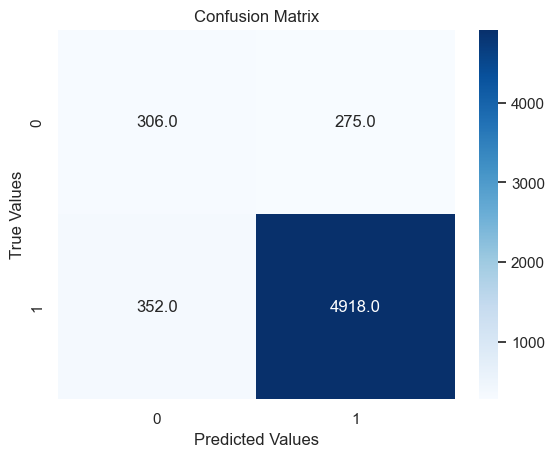

********************
********************


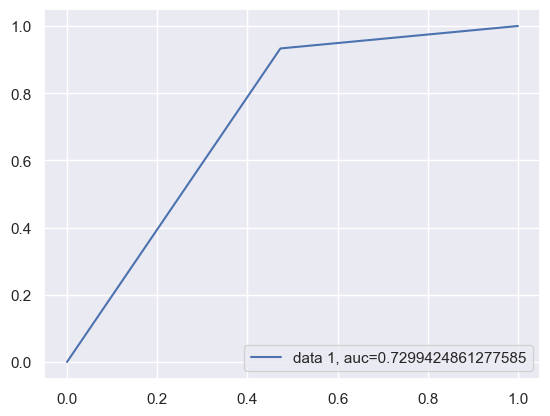

CPU times: user 438 ms, sys: 12.6 ms, total: 451 ms
Wall time: 145 ms


In [90]:
%%time
random_forest_classifier_hp.evaluate_test()

In [91]:
save_model(random_forest_classifier_hp.rf_hp_tuned_obj, random_forest_classifier_hp.model_name)

### **Metrics of All Classifier models**

In [92]:
# Creating a table which contain all the metrics
column_names = ['Metric','Logistic Regression SMOTE Train', 'Logistic Regression SMOTE Test',
                'Multinomial Naive Bayes Train','Multinomial Naive Bayes Test', 'XGBoost Train', 'XGBoost Test',
                'Decision Tree Train', 'Decision Tree Test', 'Random Forest Train', 
                'Random Forest Test', 'Random Forest HP Train', 'Random Forest HP Test']

metrics_summary = {'Metric': ['Accuracy','Precision','Recall', 'F1 Score','AUC Score'],
        'Logistic Regression SMOTE Train': logit.lr_obj.get_train_metrics(),
        'Logistic Regression SMOTE Test': logit.lr_obj.get_test_metrics(),
        'Multinomial Naive Bayes Train': multinomial_nb.nb_obj.get_train_metrics(),
        'Multinomial Naive Bayes Test': multinomial_nb.nb_obj.get_test_metrics(),
        'XGBoost Train': xgboost_classifier.xgb_c_obj.get_train_metrics(),
        'XGBoost Test': xgboost_classifier.xgb_c_obj.get_test_metrics(),
        'Decision Tree Train': dt_classifier.dt_obj.get_train_metrics(),
        'Decision Tree Test': dt_classifier.dt_obj.get_test_metrics(),
        'Random Forest Train': random_forest_classifier.rf_obj.get_train_metrics(),
        'Random Forest Test': random_forest_classifier.rf_obj.get_test_metrics(),
        'Random Forest HP Train': random_forest_classifier_hp.rf_hp_tuned_obj.get_train_metrics(),
        'Random Forest HP Test': random_forest_classifier_hp.rf_hp_tuned_obj.get_test_metrics(),
        }

metrics_df = pd.DataFrame(metrics_summary, columns = column_names)
metrics_df

,Metric,Logistic Regression SMOTE Train,Logistic Regression SMOTE Test,Multinomial Naive Bayes Train,Multinomial Naive Bayes Test,XGBoost Train,XGBoost Test,Decision Tree Train,Decision Tree Test,Random Forest Train,Random Forest Test,Random Forest HP Train,Random Forest HP Test
0,Accuracy,0.96,0.92,0.91,0.86,0.96,0.93,0.83,0.72,1.0,0.94,0.84,0.89
1,Precision,0.97,0.97,0.94,0.98,0.95,0.96,0.92,0.97,1.0,0.95,0.79,0.95
2,Recall,0.95,0.93,0.88,0.86,0.98,0.97,0.72,0.71,1.0,0.98,0.94,0.93
3,F1 Score,0.96,0.95,0.91,0.92,0.97,0.96,0.81,0.82,1.0,0.97,0.86,0.94
4,AUC Score,0.96,0.85,0.91,0.84,0.96,0.79,0.83,0.77,1.0,0.77,0.84,0.73


## **Observation: comparing the results of the various models used**
- We implemented the SMOTE to deal with class imbalance
- We have used six models to compare - `Logistic Regression`, `Multinomial Naive Bayes`, `XGBoost - with and without hyperparameter`, `Random Forest - with and without hyperparameter`, `Decision Tree`
- We can say that the `Logistic Regression`, `XGBoost` and `Random Forest` are the best performing models
#### **Out of these three, I am choosing `XGBoost` for classification**

# **Task 5: Building the Recommendation System**

We will build these two recommendation system
- User-based recommendation system
- Item-based recommendation system

In [93]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [94]:
cl_df = pd.read_pickle("savedData/preprocessed-dataframe.pkl")
cl_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_preprocess_text,reviews_complete_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",others,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphors crazy,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,good good flavor review collected part promotion,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor.,Good,dorothy w,1,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",others,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,rebecca,0,disappointed read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean not pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant less money less mess,disappoint read review look buy one couple lubricant ultimately disappointed do not even live review read starter neither boyfriend could notice sort enhance captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean not pleasant especially since lack captivate sensation expect I m disappoint pay much lube will not use could use normal personal lubricant less money less mess
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",others,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,irritation husband bought gel us gel caused irritation felt like burning skin wouldnt recommend gel,irritation husband buy gel us gel cause irritation feel like burn skin would not recommend gel


72 rows with either unknow `review_title` or unknown `reviews_username`

In [95]:
cl_df[(cl_df["reviews_title"] == "unknown") | (cl_df["reviews_username"] == "unknown")].shape

(72, 13)

In [96]:
user_recommendation_df_columns = ['id', 'name', 'reviews_rating', 'reviews_username']
user_recommendation_df = cl_df[user_recommendation_df_columns]
user_recommendation_df.head()

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


### **Dividing the data in train and test**

In [97]:
train, test = train_test_split(user_recommendation_df, test_size=0.30, random_state=42)


In [98]:
print(train.shape)
print(test.shape)

(20478, 4)
(8777, 4)


In [99]:
user_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
user_recommendation_df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Creating dummy train and test**
These dataset will be used for prediction:
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [100]:
# Copy the train dataset into dummy_train
recommendation_user_dummy_train = train.copy()


In [101]:
# The products not rated by user is marked as 1 for prediction.
recommendation_user_dummy_train['reviews_rating'] = recommendation_user_dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)


In [102]:
# Convert the dummy train dataset into matrix format
recommendation_user_dummy_train = recommendation_user_dummy_train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(1)
recommendation_user_dummy_train.head()


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [103]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"
user_input = "manny"

**Cosine Similarity**
Cosine Similarity measures how similar two vectors are by calculating the cosine of the angle between them. In our case, we'll use it to compare the `reviews_rating` columns of different products.

**Adjusted Cosine Similarity**
Adjusted Cosine Similarity is a refined version of Cosine Similarity that accounts for user-specific rating biases. Some users tend to rate items higher or lower than others, regardless of the actual quality. To address this, we adjust each user's ratings by subtracting their average rating from each individual rating. This helps to normalize ratings across users, leading to more accurate similarity comparisons. 


## **User Based Recommendation System**
### **User Similarity Matrix**
**Using adjusted Cosine** <br/>
Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [104]:
# Create Pivot the train ratings data into matrix
# In this case columns are Products and the rows are usernames.
user_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
user_recommendation_df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
mean = np.nanmean(user_recommendation_df_pivot, axis=1)
user_recommendation_df_subtracted = (user_recommendation_df_pivot.T-mean).T
user_recommendation_df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(user_recommendation_df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### **User-User Prediction**

We will predict ratings for a user by considering only those users who have a positive correlation with the target user. Users with negative correlations are excluded as they are less similar to the target user. By focusing on positively correlated users, we can make more accurate predictions based on similar preferences.


In [107]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [108]:
user_predicted_ratings = np.dot(user_correlation, user_recommendation_df_pivot.fillna(0))
print(user_predicted_ratings.shape)
user_predicted_ratings

(17790, 218)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [109]:
user_final_rating = np.multiply(user_predicted_ratings,recommendation_user_dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
save_object(user_final_rating, "user_final_rating")

# **Task 6: Recommendation of Top 20 Products to a Specified User `User-User`**

In [111]:
recommendations_user_user = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations_user_user

id
AVpfPaoqLJeJML435Xk9    74.553884
AVpe41TqilAPnD_xQH3d    30.277626
AVpe59io1cnluZ0-ZgDU    26.673776
AVpf3VOfilAPnD_xjpun    13.253695
AVpf2tw1ilAPnD_xjflC    13.181836
AVpfJP1C1cnluZ0-e3Xy    11.502760
AVpfM_ytilAPnD_xXIJb     9.547001
AVpfR5m0LJeJML436K3W     7.078396
AVpf5Z1zLJeJML43FpB-     5.378422
AVpe8gsILJeJML43y6Ed     5.023649
AVpfOmKwLJeJML435GM7     4.904194
AVpfv4TlilAPnD_xhjNS     4.549390
AVpf63aJLJeJML43F__Q     4.143523
AVpfOIrkilAPnD_xXgDG     3.728256
AVpfPnrU1cnluZ0-g9rL     3.691839
AVpfEqruilAPnD_xUWDr     3.331550
AVpfRYbSilAPnD_xYkD4     3.263956
AVpe-PJnLJeJML43ziaj     3.263956
AVpfBU2S1cnluZ0-cJsO     3.263956
AVpe5JOgilAPnD_xQPfE     3.077287
Name: manny, dtype: float64

In [112]:
#display the top 20 product id, name and similarity_score 
final_recommendations_user = pd.DataFrame({'product_id': recommendations_user_user.index, 'similarity_score' : recommendations_user_user})
final_recommendations_user.reset_index(drop=True)
pd.merge(final_recommendations_user, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,74.553884
2313,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),30.277626
2823,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),26.673776
3285,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,13.253695
9206,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),13.181836
9662,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,11.502760
11100,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,9.547001
11291,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,7.078396
11439,AVpf5Z1zLJeJML43FpB-,"Lysol Concentrate Deodorizing Cleaner, Original Scent",5.378422
11542,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",5.023649


In [113]:
def get_top_recommendation_users(users):
    new_df = pd.DataFrame()
    for user_input in users:
        try:
            temp_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
            temp = temp_recommendations.to_frame().reset_index()
            temp = temp[temp.columns.difference(['id'])].T
            temp.columns = [f"product{ind}" for ind in range(len(temp.columns))]
            temp.insert(0, "user", user_input)
            
            if len(new_df) != 0:
                new_df = pd.concat([new_df, temp], ignore_index=True, axis=0)
            else:
                new_df = temp

        except:
            continue

    return new_df

In [114]:
temp_user_recommendation_df = get_top_recommendation_users(train.reviews_username.unique())

In [115]:
save_object(temp_user_recommendation_df.sort_values(by=["product0"], ascending=False).head(10), "best_recommendation_users")

#### **Users with best product recommendations**

In [116]:
temp_user_recommendation_df.sort_values(by=["product0"], ascending=False).head(10)

,user,product0,product1,product2,product3,product4,product5,product6,product7,product8,...,product10,product11,product12,product13,product14,product15,product16,product17,product18,product19
6151,manny,74.553884,30.277626,26.673776,13.253695,13.181836,11.502760,9.547001,7.078396,5.378422,...,4.904194,4.549390,4.143523,3.728256,3.691839,3.331550,3.263956,3.263956,3.263956,3.077287
1449,moerena,74.067436,21.816133,19.066274,19.030876,16.617397,10.036487,10.016632,8.697712,8.413393,...,7.197199,5.606674,4.892243,4.656636,4.119252,3.891039,3.891039,3.865680,3.790994,3.448617
2769,nana,70.577337,56.694429,49.406397,31.322992,16.123417,13.976228,11.319356,10.725913,10.260420,...,9.314261,9.240835,8.892015,8.442560,7.782452,7.761607,7.014709,7.002242,6.841551,6.597396
1275,vicki,70.389129,57.651201,43.615622,34.720689,13.211525,11.145445,10.053928,9.047835,8.968361,...,8.576103,8.013447,7.987062,7.681255,6.595717,5.653617,5.212496,5.189562,5.157319,5.090876
2988,viewer,68.300130,57.014452,47.626200,39.359921,30.819626,13.134011,11.452792,10.194899,9.922057,...,8.717697,8.480747,8.432344,8.371707,7.822141,7.375848,7.278232,5.338724,4.829629,4.477209
2010,brandon,68.181430,54.455826,42.289230,30.394557,30.362211,11.004222,10.194899,9.611441,8.811906,...,8.685644,7.928822,7.782452,7.413893,7.278232,6.811862,5.828120,5.739426,5.317702,5.159947
3171,ronnie,67.857236,48.294413,31.752083,29.578719,13.730138,11.378891,10.699978,9.573047,9.570263,...,8.396605,8.294562,8.186615,7.845243,7.828421,7.768277,7.623787,7.337366,7.086110,6.734680
3896,thom,66.529931,53.025387,48.623608,41.477352,30.697828,12.849890,11.499159,11.066420,10.226556,...,9.172220,8.949494,8.418798,8.306439,7.337366,6.978337,6.613531,6.454689,6.413566,6.220085
9535,chas,66.529931,53.025387,48.623608,41.477352,30.697828,12.849890,11.499159,11.066420,10.226556,...,9.172220,8.949494,8.418798,8.306439,7.337366,6.978337,6.613531,6.454689,6.413566,6.220085
505,adam,66.096354,45.845239,40.217108,29.455278,29.377614,12.342892,10.981117,10.710738,9.453713,...,8.860351,8.724332,8.510261,8.228932,7.337366,7.273503,7.086110,6.978337,6.824340,6.613531


#### **Evaluation User-User**

In [117]:
# Find out the common users of test and train dataset.
common_users = test[test.reviews_username.isin(train.reviews_username)]
common_users.shape

(1892, 4)

In [118]:
common_users.head()

,id,name,reviews_rating,reviews_username
19958,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,mommy2three
8516,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,angie0104
18684,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,4,babe
21876,AVpfMpZ51cnluZ0-f_L9,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,5,alexis
25458,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,ross


In [119]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common_users,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,...,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17780,17781,17782,17783,17784,17785,17786,17787,17788,17789
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
user_correlation_df[user_column] = user_recommendation_df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17780,17781,17782,17783,17784,17785,17786,17787,17788,17789
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
list_name = common_users.reviews_username.tolist()

user_correlation_df.columns = user_recommendation_df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [123]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

In [124]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [125]:
recommendation_user_dummy_test = common_users.copy()

recommendation_user_dummy_test[value_column] = recommendation_user_dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
recommendation_user_dummy_test = pd.pivot_table(recommendation_user_dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)


In [126]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,...,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
recommendation_user_dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,...,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,recommendation_user_dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,...,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.**

In [129]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [130]:
common_users_ = pd.pivot_table(common_users, index = user_column, columns = product_column, values = value_column)


In [131]:
total_non_nan = np.count_nonzero(~np.isnan(y))


In [132]:
temp_test_df = get_top_recommendation_users(test.reviews_username.unique())

In [133]:
temp_test_df.sort_values(by=["product0"], ascending=False).head(10)

,user,product0,product1,product2,product3,product4,product5,product6,product7,product8,...,product10,product11,product12,product13,product14,product15,product16,product17,product18,product19
571,manny,74.553884,30.277626,26.673776,13.253695,13.181836,11.502760,9.547001,7.078396,5.378422,...,4.904194,4.549390,4.143523,3.728256,3.691839,3.331550,3.263956,3.263956,3.263956,3.077287
1555,vicki,70.389129,57.651201,43.615622,34.720689,13.211525,11.145445,10.053928,9.047835,8.968361,...,8.576103,8.013447,7.987062,7.681255,6.595717,5.653617,5.212496,5.189562,5.157319,5.090876
1181,brandon,68.181430,54.455826,42.289230,30.394557,30.362211,11.004222,10.194899,9.611441,8.811906,...,8.685644,7.928822,7.782452,7.413893,7.278232,6.811862,5.828120,5.739426,5.317702,5.159947
67,chas,66.529931,53.025387,48.623608,41.477352,30.697828,12.849890,11.499159,11.066420,10.226556,...,9.172220,8.949494,8.418798,8.306439,7.337366,6.978337,6.613531,6.454689,6.413566,6.220085
175,adam,66.096354,45.845239,40.217108,29.455278,29.377614,12.342892,10.981117,10.710738,9.453713,...,8.860351,8.724332,8.510261,8.228932,7.337366,7.273503,7.086110,6.978337,6.824340,6.613531
878,robert,65.163173,28.201435,25.575304,13.692511,12.172277,9.424490,7.580041,5.047125,4.701621,...,4.446839,4.356348,3.827659,3.750000,3.750000,3.750000,3.651118,3.535534,3.535534,3.305324
1301,jimmy,64.589525,52.861891,38.052271,29.294426,28.944883,12.059960,10.348706,9.616993,9.394620,...,8.532749,7.952292,7.895069,7.647249,7.537273,7.103924,6.863324,6.605217,4.677476,4.488549
776,chrissy,63.843874,50.097914,43.462303,36.683365,28.375215,27.848502,10.226556,8.970554,8.966358,...,8.199462,7.644235,7.463914,7.440169,7.337366,6.705564,6.613531,6.561823,6.220085,4.553418
782,drew,63.555636,43.774830,29.829907,28.401334,13.234265,10.092538,9.932488,9.430843,8.860351,...,8.396605,8.240811,8.219839,8.133037,7.337366,7.294089,6.986209,6.824340,6.422285,6.289016
1221,joel,63.365408,51.886801,41.608215,28.723801,28.094492,10.092538,9.932488,8.610013,8.563271,...,8.292772,8.219839,7.860265,7.374785,7.337366,6.986209,6.422285,5.127423,5.044912,4.913918


#### **RMSE of `User-User`**

In [134]:
rmse_user_user = (sum(sum((common_users_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

2.3931530272458366


## **Item Based Recommendation System**

### **Item Similarity Matrix**
Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie.

In [135]:
item_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id',values='reviews_rating').T
item_recommendation_df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,1.11E+24,1085,1143mom,...,zpalma,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
mean = np.nanmean(item_recommendation_df_pivot, axis=1)
item_recommendation_df_subtracted = (item_recommendation_df_pivot.T-mean).T
item_recommendation_df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,1.11E+24,1085,1143mom,...,zpalma,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.09375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Cosine similarity using pairwise distances approach**

In [137]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(item_recommendation_df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


**correlation only for which the value is greater than 0. (Positively correlated)**

In [138]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### **Prediction - `Item-Item`**

In [139]:
item_predicted_ratings = np.dot((item_recommendation_df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.01190255, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00364662, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00911654, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00729323, 0.        ,
        0.        ]])

#### **Filtering the rating only for the products not rated by the user for recommendation**

In [140]:
item_final_rating = np.multiply(item_predicted_ratings, recommendation_user_dummy_train)
item_final_rating.head()



id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.000604,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.011903,0.0,0.0
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.018160,0.0,...,0.001341,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.030267,0.0,...,0.002236,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.024213,0.0,...,0.001789,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.002464,0.003665,0.002407,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.009117,0.0,0.0


# **Task 6: Recommendation of Top 20 Products to a Specified User `Item-Item`**

In [141]:
recommendations_item_item = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations_item_item

id
AVpfOIrkilAPnD_xXgDG    0.221069
AVpfv4TlilAPnD_xhjNS    0.087152
AVpfkQkcLJeJML43_kEC    0.069913
AVpfthSailAPnD_xg3ON    0.068964
AVpf0pfrilAPnD_xi6s_    0.048274
AVpe6PCDLJeJML43yFQH    0.047824
AVpfOmKwLJeJML435GM7    0.032066
AVpf2tw1ilAPnD_xjflC    0.027454
AVpe8gsILJeJML43y6Ed    0.027205
AVpe59io1cnluZ0-ZgDU    0.024612
AVpe5c23LJeJML43xybi    0.024377
AVpf0thK1cnluZ0-r8vR    0.023955
AVpfCuzrilAPnD_xTroT    0.023391
AVpe31o71cnluZ0-YrSD    0.022211
AVpe7sl91cnluZ0-aI1Y    0.021966
AVpfM_ytilAPnD_xXIJb    0.021875
AVpe7GIELJeJML43yZfu    0.021788
AVpfov9TLJeJML43A7B0    0.020920
AVpe9W4D1cnluZ0-avf0    0.019541
AVpfDI3xilAPnD_xTz-k    0.019007
Name: manny, dtype: float64

In [142]:
#display the top 20 product id, name and similarity_score 
final_recommendations_item = pd.DataFrame({'product_id': recommendations_item_item.index, 'similarity_score' : recommendations_item_item})
final_recommendations_item.reset_index(drop=True)
pd.merge(final_recommendations_item, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.221069
106,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter (cd),0.087152
109,AVpfkQkcLJeJML43_kEC,Cococare 100% Natural Castor Oil,0.069913
111,AVpfthSailAPnD_xg3ON,"Musselman Apple Sauce, Cinnamon, 48oz",0.068964
116,AVpf0pfrilAPnD_xi6s_,Nearly Natural 5.5' Bamboo W/decorative Planter,0.048274
122,AVpe6PCDLJeJML43yFQH,Wagan Smartac 80watt Inverter With Usb,0.047824
126,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,0.032066
378,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),0.027454
834,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",0.027205
1062,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),0.024612


#### **Best recommended users - item recommendation**

In [143]:
def get_top_recommendation_items(users):
    new_df = pd.DataFrame()
    for user_input in users:
        try:
            temp_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
            temp = temp_recommendations.to_frame().reset_index()
            temp = temp[temp.columns.difference(['id'])].T
            temp.columns = [f"product{ind}" for ind in range(len(temp.columns))]
            temp.insert(0, "user", user_input)
            
            if len(new_df) != 0:
                new_df = pd.concat([new_df, temp], ignore_index=True, axis=0)
            else:
                new_df = temp

        except:
            continue

    return new_df

In [144]:
temp_item_recommendation_df = get_top_recommendation_items(train.reviews_username.unique())

In [145]:
temp_item_recommendation_df.sort_values(by=["product0"], ascending=False).head(10)

,user,product0,product1,product2,product3,product4,product5,product6,product7,product8,...,product10,product11,product12,product13,product14,product15,product16,product17,product18,product19
8151,dfwatheartgirl,1.844855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
504,cdguerrero,1.844855,0.023411,0.019665,0.013698,0.009192,0.004062,0.002464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
1991,gelon33,1.844855,0.023411,0.019665,0.013698,0.009192,0.004062,0.002464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
4649,rayray,1.844855,0.731307,0.242600,0.027092,0.024815,0.023539,0.019219,0.014117,0.013602,...,0.012134,0.011373,0.011037,0.010289,0.00962,0.00937,0.009147,0.009117,0.008516,0.008181
1757,kimmicha,1.844855,0.023411,0.019665,0.013698,0.009192,0.004062,0.002464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
8110,coupongirl63301,1.844855,0.023411,0.019665,0.013698,0.009192,0.004062,0.002464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
10921,traviemom,1.844855,0.023411,0.019665,0.013698,0.009192,0.004062,0.002464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
14687,violagirl522,1.844855,0.023411,0.019665,0.013698,0.009192,0.004062,0.002464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
10920,momandteacher,1.844855,0.023411,0.019665,0.013698,0.009192,0.004062,0.002464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
13944,purple22,1.844855,0.023411,0.019665,0.013698,0.009192,0.004062,0.002464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000


#### **Evaluation - Item Item**
Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [146]:
common_items = test[test['id'].isin(train['id'])]
print(common_items.shape)
common_items.head()

(8759, 4)


,id,name,reviews_rating,reviews_username
10776,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,brant
27425,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),4,kingsixx
1019,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),5,grangolfer
21235,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,rohzgirl
14861,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,soccermom1


#### **Item Based Matrix**

In [147]:
common_item_based_matrix =  common_items.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
common_item_based_matrix.shape

(158, 8181)

In [148]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,215,216,217
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002029,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [149]:
item_correlation_df['productId'] = item_recommendation_df_subtracted.index
item_correlation_df.set_index('productId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,215,216,217
productId,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002029,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [150]:
item_correlation_df.columns = item_recommendation_df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(common_items['id'].tolist())]

In [151]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(common_items['id'].tolist())]
item_correlation_df_3 = item_correlation_df_2.T

In [152]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V
productId,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003144,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002029
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.006919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [153]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02415616, 0.        , 0.00532649, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03037509, 0.        , ..., 0.        , 0.00911654,
        0.05062516],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [154]:
dummy_test_recommendation = common_items.copy()
dummy_test_recommendation['reviews_rating'] = dummy_test_recommendation['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test_recommendation = dummy_test_recommendation.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)


In [155]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test_recommendation)

**The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.**

In [156]:
common_items_ = common_items.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [157]:
X  = common_item_predicted_ratings.copy()
X = X[X>0]

# Applying MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [158]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [159]:
rmse_item_item = (sum(sum((common_items_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.5701485985345913


### **Selecting Best Recommendation Model:**

In [160]:
print("RMSE of User Based Recommendation System: ", rmse_user_user)
print("RMSE of Item Based Recommendation System: ", rmse_item_item)

if rmse_user_user < rmse_item_item:
  print("User-User Based Model is  Recommended")
else:
  print("Item-Item Based Model is  Recommended")

RMSE of User Based Recommendation System:  2.3931530272458366
RMSE of Item Based Recommendation System:  3.5701485985345913
User-User Based Model is  Recommended


On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value `(~2.3)` as compared to Item-Item based recommendation systm. <br/>
#### **`User User Recommendation` system is chosen**.

## **Improving the recommendations using the sentiment analysis model**

### Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

#### Load the cleaned dataframe

In [161]:
clean_df = pd.read_pickle("savedData/preprocessed-dataframe.pkl")
clean_df_recommended = clean_df[['id','name','reviews_complete_text', 'user_sentiment']]

#### Load the user final rating

In [162]:
user_final_rating = pd.read_pickle("savedData/user_final_rating.pkl")

#### Load the Vectorizer

In [163]:
file = open("savedData/tfidf-vectorizer.pkl",'rb')
vectorizer = pickle.load(file)
file.close()

#### Load the Classification model

In [164]:
# LR SMOTE
file = open("savedData/models/logistic_regression.pkl",'rb')
lr_smote_obj = pickle.load(file)
file.close()

# XGBoost
file = open("savedData/models/xgboost_classifier.pkl",'rb')
xg_obj = pickle.load(file)
file.close()

# RF
# random_forest_classifier_20241114-111106.pkl
file = open("savedData/models/random_forest_classifier.pkl",'rb')
rf_obj = pickle.load(file)
file.close()

In [165]:
user_input = "rebecca"

# **Task 6: Recommendation of Top 20 Products to a Specified**

In [166]:
def get_top20_products_for_user(user):
    # get the top 20  recommedation using the user_final_rating
    top20_reco = user_final_rating.loc[user].sort_values(ascending=False)[0:20]
    recommendations = pd.DataFrame({'product_id': top20_reco.index, 'similarity_score' : top20_reco})
    recommendations.reset_index(drop=True)
    result = pd.merge(recommendations, clean_df_recommended, on="id")[["id", "name", "similarity_score"]].drop_duplicates()
    
    return result

In [167]:
get_top20_products_for_user(user_input)

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,29.592094
3325,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),10.672246
3994,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),9.868508
4662,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,9.466633
6701,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),8.450727
7458,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,6.623078
7722,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",6.537746
8032,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,5.489594
8204,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",4.742484
9077,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,4.202777


# **Task 7: Fine-Tuning the Recommendation System and Recommendation of Top 5 Products**

### Fine tune and optimise the recommendation using the user-recommendation and classification model

In [168]:
def get_top5_user_recommendations(user, model):
  if user in user_final_rating.index:
    # get the top 20  recommedation using the user_final_rating
    top20_reco = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
    # get the product recommedation using the orig data used for trained model
    common_top20_reco = clean_df_recommended[clean_df['id'].isin(top20_reco)]
    # Apply the TFIDF Vectorizer for the given 20 products to convert data in reqd format for modeling
    X =  vectorizer.transform(common_top20_reco['reviews_complete_text'].values.astype(str))

    # Using the model from param to predict
    model.set_test_data(X)
    common_top20_reco['sentiment_pred']= model.predict()

    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    temp_df = common_top20_reco.groupby(by='name').sum()
    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    sent_df = temp_df[['sentiment_pred']]
    sent_df.columns = ['positive_sentiment_count']
    # Create a column to measure the total sentiment count
    sent_df['total_sentiment_count'] = common_top20_reco.groupby(by='name')['sentiment_pred'].count()
    # Calculate the positive sentiment percentage
    sent_df['positive_sentiment_percent'] = np.round(sent_df['positive_sentiment_count']/sent_df['total_sentiment_count']*100,2)
    # Return top 5 recommended products to the user
    result = sent_df.sort_values(by='positive_sentiment_percent', ascending=False)[:5]
    return result
  else:
    print(f"User name {user} doesn't exist")

## Recommendatons from `Linear Regression` and `User-User` filtering

In [169]:
get_top5_user_recommendations(user_input, lr_smote_obj)

,positive_sentiment_count,total_sentiment_count,positive_sentiment_percent
name,,,
Clorox Disinfecting Bathroom Cleaner,2010,2039,98.58
Chester's Cheese Flavored Puffcorn Snacks,165,172,95.93
The Resident Evil Collection 5 Discs (blu-Ray),803,845,95.03
Red (special Edition) (dvdvideo),626,669,93.57
Jolly Time Select Premium Yellow Pop Corn,25,27,92.59


## Recommendatons from `XGBoost` and `User-User` filtering

In [170]:
get_top5_user_recommendations(user_input, xg_obj)

,positive_sentiment_count,total_sentiment_count,positive_sentiment_percent
name,,,
Clorox Disinfecting Bathroom Cleaner,2024,2039,99.26
Chester's Cheese Flavored Puffcorn Snacks,168,172,97.67
Vaseline Intensive Care Lip Therapy Cocoa Butter,153,158,96.84
The Resident Evil Collection 5 Discs (blu-Ray),812,845,96.09
Red (special Edition) (dvdvideo),641,669,95.81


## Recommendatons from `Random Forest` and `User-User` filtering
- model name: `xgboost_classifier.pkl`

In [171]:
get_top5_user_recommendations(user_input, rf_obj)

,positive_sentiment_count,total_sentiment_count,positive_sentiment_percent
name,,,
Clorox Disinfecting Bathroom Cleaner,2014,2039,98.77
Chester's Cheese Flavored Puffcorn Snacks,167,172,97.09
Red (special Edition) (dvdvideo),649,669,97.01
The Resident Evil Collection 5 Discs (blu-Ray),814,845,96.33
Jolly Time Select Premium Yellow Pop Corn,26,27,96.30


# **Our selection was `XGBoost and User-User` filtering**
#### **This is our final top 5 recommendation for the user**

In [172]:
get_top5_user_recommendations(user_input, xg_obj)

,positive_sentiment_count,total_sentiment_count,positive_sentiment_percent
name,,,
Clorox Disinfecting Bathroom Cleaner,2024,2039,99.26
Chester's Cheese Flavored Puffcorn Snacks,168,172,97.67
Vaseline Intensive Care Lip Therapy Cocoa Butter,153,158,96.84
The Resident Evil Collection 5 Discs (blu-Ray),812,845,96.09
Red (special Edition) (dvdvideo),641,669,95.81
